In [512]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sys
import sqlite3  

# show all columns in pandas
pd.set_option('display.max_columns', None)

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from type hints import tuple
from typing import Tuple

from tqdm.auto import tqdm

import wandb

# import r2score
from sklearn.metrics import r2_score
# import mean squared error
from sklearn.metrics import mean_squared_error

from pathlib import Path

# increase number of rows to display
pd.set_option('display.max_rows', 1000)

import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

proj_path = Path("/content/drive/MyDrive/Project/Strava/")


In [567]:
# use sqlite3 to connect to the database strava.db
# locally
conn = sqlite3.connect('strava.db')
# when on google colab
#conn = sqlite3.connect(proj_path / 'strava.db')

c = conn.cursor()
# use pandas to read the table 'activities' from the database
df = pd.read_sql_query("SELECT * FROM activities", conn)

# use pandas to read activity_details from the database
df_hr = pd.read_sql_query("SELECT * FROM activity_details", conn)

# close the connection to the database
conn.close()


In [568]:

# turn off pandas PerformanceWarning error  
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# add a suffer_score missing indicator column
df["suffer_score_missing"] = df["suffer_score"].isnull()
df["suffer_score_missing"] = df["suffer_score_missing"].astype('int')

# add a suffer_score missing indicator column
df["calories_missing"] = df["calories"].isnull()
df["calories_missing"] = df["calories_missing"].astype('int')
df["calories"] = df["calories"].fillna(0)


df["start_date"] = pd.to_datetime(df["start_date"])
df["date"] = pd.to_datetime(df["date"])



df = df.sort_values("start_date", ascending=True)

# obtain number of days between current start_date and previous start_date for each row in df 
df["days_since"] = df.start_date.diff().dt.days
# get suffer score from previous row for each row in df 
df["suffer_score_prev"] = df.suffer_score.shift(1)
# get heartrate from previous row for each row in df
df["mean_hr"] = df.mean_hr.shift(1)
# get max_hr from previous row for each row in df
df["max_hr"] = df.max_hr.shift(1)
# get watts from previous row for each row in df
df["mean_watts"] = df.mean_watts.shift(1)
# get elapsed_time from previous row for each row in df
df["moving_time_min"] = df.moving_time_min.shift(1)

# create a full date range for the dataframe for every day from min to max date in the dataframe 
# and then merge the dataframe with the full date range
# this will create a dataframe with all dates and all columns from the original dataframe
# and fill all missing values with NaN
df_full = pd.DataFrame({'date': pd.date_range(df.date.min(), df.date.max(), freq='1d')})
df_full = df_full.merge(df, on='date', how='left')

# if id is null fill all float columns with 0
cond = df_full["activity_id"].isnull()
df_full.loc[cond, df_full.select_dtypes("float").columns] = 0

# create rolling mean, std, max features for float columns for 7, 14, 30, 60, 90 days but dont include current row
for col in df_full.select_dtypes("float").columns:
    if col not in ["activity_id", "hour"]:
        for days in [7, 14, 30, 60, 90]:
            df_full[f"{col}_rolling_mean_{days}"] = df_full[col].rolling(days).mean().shift(1)
            df_full[f"{col}_rolling_std_{days}"] = df_full[col].rolling(days).std().shift(1)
            df_full[f"{col}_rolling_max_{days}"] = df_full[col].rolling(days).max().shift(1)
            #df_full[f"{col}_rolling_mean_{days}"] = df_full[col].rolling(days).mean()
            #df_full[f"{col}_rolling_std_{days}"] = df_full[col].rolling(days).std()
            #df_full[f"{col}_rolling_max_{days}"] = df_full[col].rolling(days).max()

# if id is greater than 0 create a new column with the value 1 else 0
# days since last traning/activity?!
#df_full["id_not_null"] = df_full["activity_id"].apply(lambda x: 1 if x > 0 else 0)
#df_full["cumsum"] = df_full["id_not_null"].cumsum()
#df_full["cumcount"] = df_full.groupby("cumsum").cumcount()
#df_full["cumcount_shift"] = df_full["cumcount"].shift(1)

df_full["name"] = df_full["name"].str.replace("The Sufferfest", "Wahoo SYSTM", regex=False)


# drop if activity_id is 0
df_full = df_full[df_full["activity_id"] > 0]

# drop columns suffer_score, max_hr and mean_hr
df_full = df_full.drop(["suffer_score", "max_hr", "mean_hr", "calories", "suffer_score_missing", "calories_missing"], axis=1)

In [534]:
df_full.select_dtypes(include="number").tail()

,activity_id,mean_watts,moving_time,elapsed_time,weighted_mean_watts,elev_gain,kilojoules,average_speed,distance,year,hour,moving_time_min,elapsed_time_min,days_since,suffer_score_prev,suffer_score_rolling_mean_7,suffer_score_rolling_std_7,suffer_score_rolling_max_7,suffer_score_rolling_mean_14,suffer_score_rolling_std_14,suffer_score_rolling_max_14,suffer_score_rolling_mean_30,suffer_score_rolling_std_30,suffer_score_rolling_max_30,suffer_score_rolling_mean_60,suffer_score_rolling_std_60,suffer_score_rolling_max_60,suffer_score_rolling_mean_90,suffer_score_rolling_std_90,suffer_score_rolling_max_90,max_hr_rolling_mean_7,max_hr_rolling_std_7,max_hr_rolling_max_7,max_hr_rolling_mean_14,max_hr_rolling_std_14,max_hr_rolling_max_14,max_hr_rolling_mean_30,max_hr_rolling_std_30,max_hr_rolling_max_30,max_hr_rolling_mean_60,max_hr_rolling_std_60,max_hr_rolling_max_60,max_hr_rolling_mean_90,max_hr_rolling_std_90,max_hr_rolling_max_90,mean_hr_rolling_mean_7,mean_hr_rolling_std_7,mean_hr_rolling_max_7,mean_hr_rolling_mean_14,mean_hr_rolling_std_14,mean_hr_rolling_max_14,mean_hr_rolling_mean_30,mean_hr_rolling_std_30,mean_hr_rolling_max_30,mean_hr_rolling_mean_60,mean_hr_rolling_std_60,mean_hr_rolling_max_60,mean_hr_rolling_mean_90,mean_hr_rolling_std_90,mean_hr_rolling_max_90,mean_watts_rolling_mean_7,mean_watts_rolling_std_7,mean_watts_rolling_max_7,mean_watts_rolling_mean_14,mean_watts_rolling_std_14,mean_watts_rolling_max_14,mean_watts_rolling_mean_30,mean_watts_rolling_std_30,mean_watts_rolling_max_30,mean_watts_rolling_mean_60,mean_watts_rolling_std_60,mean_watts_rolling_max_60,mean_watts_rolling_mean_90,mean_watts_rolling_std_90,mean_watts_rolling_max_90,calories_rolling_mean_7,calories_rolling_std_7,calories_rolling_max_7,calories_rolling_mean_14,calories_rolling_std_14,calories_rolling_max_14,calories_rolling_mean_30,calories_rolling_std_30,calories_rolling_max_30,calories_rolling_mean_60,calories_rolling_std_60,calories_rolling_max_60,calories_rolling_mean_90,calories_rolling_std_90,calories_rolling_max_90,moving_time_rolling_mean_7,moving_time_rolling_std_7,moving_time_rolling_max_7,moving_time_rolling_mean_14,moving_time_rolling_std_14,moving_time_rolling_max_14,moving_time_rolling_mean_30,moving_time_rolling_std_30,moving_time_rolling_max_30,moving_time_rolling_mean_60,moving_time_rolling_std_60,moving_time_rolling_max_60,moving_time_rolling_mean_90,moving_time_rolling_std_90,moving_time_rolling_max_90,elapsed_time_rolling_mean_7,elapsed_time_rolling_std_7,elapsed_time_rolling_max_7,elapsed_time_rolling_mean_14,elapsed_time_rolling_std_14,elapsed_time_rolling_max_14,elapsed_time_rolling_mean_30,elapsed_time_rolling_std_30,elapsed_time_rolling_max_30,elapsed_time_rolling_mean_60,elapsed_time_rolling_std_60,elapsed_time_rolling_max_60,elapsed_time_rolling_mean_90,elapsed_time_rolling_std_90,elapsed_time_rolling_max_90,weighted_mean_watts_rolling_mean_7,weighted_mean_watts_rolling_std_7,weighted_mean_watts_rolling_max_7,weighted_mean_watts_rolling_mean_14,weighted_mean_watts_rolling_std_14,weighted_mean_watts_rolling_max_14,weighted_mean_watts_rolling_mean_30,weighted_mean_watts_rolling_std_30,weighted_mean_watts_rolling_max_30,weighted_mean_watts_rolling_mean_60,weighted_mean_watts_rolling_std_60,weighted_mean_watts_rolling_max_60,weighted_mean_watts_rolling_mean_90,weighted_mean_watts_rolling_std_90,weighted_mean_watts_rolling_max_90,elev_gain_rolling_mean_7,elev_gain_rolling_std_7,elev_gain_rolling_max_7,elev_gain_rolling_mean_14,elev_gain_rolling_std_14,elev_gain_rolling_max_14,elev_gain_rolling_mean_30,elev_gain_rolling_std_30,elev_gain_rolling_max_30,elev_gain_rolling_mean_60,elev_gain_rolling_std_60,elev_gain_rolling_max_60,elev_gain_rolling_mean_90,elev_gain_rolling_std_90,elev_gain_rolling_max_90,kilojoules_rolling_mean_7,kilojoules_rolling_std_7,kilojoules_rolling_max_7,kilojoules_rolling_mean_14,kilojoules_rolling_std_14,kilojoules_rolling_max_14,kilojoules_rolling_mean_30,kilojoules_rolling_std_30,kilojoules_rolling_

In [569]:
# add column to indicate if heartrate is null
df_hr["heartrate_missing"] = df_hr.heartrate.isnull()
# check if heartrate == 0 for only one timestamp in a row
df_hr["hr_eq_0"] = df_hr.heartrate == 0
df_hr["hr_eq_0_shift1"] = df_hr.hr_eq_0.shift(1)
#
df_hr["hr_eq_0_shift_1"] = df_hr.hr_eq_0.shift(-1)

df_hr["hr_eq_0_shift1"].fillna(False, inplace=True)
df_hr["hr_eq_0_shift_1"].fillna(False, inplace=True)

# more complicated code to accomplish the same thing
#df_hr["shifted"] = df_hr["hr_eq_0"] != df_hr["hr_eq_0_shift"]

#df_hr["hr_eq_0_and_shifted"] = df_hr["hr_eq_0"] & df_hr["shifted"]
#df_hr["prev_hr_eq_0_and_shifted"] = df_hr["hr_eq_0_shift"] & df_hr["shifted"]
#df_hr["hr_shift_check"] = df_hr["hr_eq_0_and_shifted"] | df_hr["prev_hr_eq_0_and_shifted"]

#df_hr["hr_shift_check_cumsum"] = df_hr.groupby("activity_id")["hr_shift_check"].cumsum()
#df_hr["cumsum_count"] = df_hr.groupby(["activity_id", "hr_shift_check_cumsum"])["hr_shift_check_cumsum"].transform("count")

In [570]:
df_hr["hr_eq_0_and_shifted"] = df_hr["hr_eq_0"] != df_hr["hr_eq_0_shift1"]
df_hr["hr_eq_0_shifted_cumsum"] = df_hr.groupby("activity_id")["hr_eq_0_and_shifted"].cumsum()
df_hr["hr_eq_0_shifted_cumsum_count"] = df_hr.groupby(["activity_id", "hr_eq_0_shifted_cumsum"])["hr_eq_0_shifted_cumsum"].transform("count")

cond1 = df_hr.hr_eq_0_shifted_cumsum > 1
cond2 = df_hr.heartrate == 0
# set heartrate to null if hr_eq_0_shifted_cumsum > 1 and heartrate == 0
df_hr.loc[cond1 & cond2, "heartrate"] = np.nan
# make linear interpolation of heartrate if heartrate is null
df_hr["heartrate"] = df_hr.groupby("activity_id")["heartrate"].transform(lambda x: x.interpolate(method="linear"))

In [571]:
cond = df_hr["hr_eq_0"] & ~df_hr["hr_eq_0_shift1"] & ~df_hr["hr_eq_0_shift_1"]
# if cond set to nan
df_hr.loc[cond, "heartrate"] = np.nan
# use linear interpolation to fill in the missing values
df_hr["heartrate"] = df_hr.groupby("activity_id")["heartrate"].transform(lambda x: x.interpolate(method="linear"))

In [572]:
cond = df_hr.activity_id.isin(nine_hammers_activities)
cond2 = df_hr.heartrate < 10
print(df_hr[cond & cond2].activity_id.unique().tolist())
df_hr[(df_hr.activity_id == 3065631046) & cond2].head(100)
cond3 = df_hr.activity_id.isin([6103753599])
df_hr[cond & cond2 & ~cond3].head(100)



[6103753599, 3357980775, 3241849794, 3126326839, 3086063316, 3004307546]


,activity_id,time,watts,heartrate,distance,velocity_smooth,altitude,cadence,heartrate_missing,hr_eq_0,hr_eq_0_shift1,hr_eq_0_shift_1,hr_eq_0_and_shifted,hr_eq_0_shifted_cumsum,hr_eq_0_shifted_cumsum_count
678991,3357980775,0,94.0,0.0,1.0,0.0,NaN,NaN,False,True,False,True,True,1,7
678992,3357980775,1,84.0,0.0,2.0,1.0,NaN,NaN,False,True,True,True,False,1,7
678993,3357980775,2,52.0,0.0,4.0,1.5,NaN,NaN,False,True,True,True,False,1,7
678994,3357980775,3,96.0,0.0,6.0,1.7,NaN,NaN,False,True,True,True,False,1,7
678995,3357980775,4,122.0,0.0,9.0,2.0,NaN,NaN,False,True,True,True,False,1,7
678996,3357980775,5,120.0,0.0,12.0,2.2,NaN,NaN,False,True,True,True,False,1,7
678997,3357980775,6,119.0,0.0,15.0,2.6,NaN,NaN,False,True,True,False,False,1,7
708791,3241849794,0,0.0,0.0,0.0,0.0,NaN,NaN,False,True,False,True,True,1,3
708792,3241849794,1,0.0,0.0,0.0,0.0,NaN,NaN,False,True,True,True,False,1,3
708793,3241849794,2,0.0,0.0,0.0,0.0,NaN,NaN,False,True,True,False,False,1,3


In [573]:
df_hr["joules"] = df_hr.groupby("activity_id")["watts"].cumsum()
df_hr["watts_rolling"] = df_hr.groupby("activity_id")["watts"].rolling(100).mean().reset_index(0,drop=True)
# for variable watts_rolling fill missing with watts
df_hr["watts_rolling"] = df_hr["watts_rolling"].fillna(df_hr["watts"])

In [574]:
cond_nine = df.name.str.lower().str.contains("nine")
print(len(df[cond]))
df[cond_nine].sort_values("date", ascending=False).head(2)
cond_hr = df["mean_hr"].notna()

0


C:\Users\jerke\AppData\Local\Temp\ipykernel_14424\4196705495.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(df[cond]))


In [575]:
cond = df.activity_id.isin([7119038757, 8031217762])
#cond = df.type == "VirtualRide"
print(df.loc[cond, "date"].values, df.loc[cond, "name"].values)

['2022-05-10T00:00:00.000000000' '2022-10-28T00:00:00.000000000'] ['Wahoo SYSTM: Nine Hammers' 'Wahoo SYSTM: Nine Hammers']


In [576]:
nine_hammers_activities = df[cond_nine & cond_hr].activity_id.to_list()

In [577]:
[nine_hammers_activities[-1]]

[8031217762]

In [578]:
cond = df_hr.activity_id.isin(nine_hammers_activities)
ids_set = set(df_hr[cond].activity_id.unique().tolist())
print(len(ids_set))
print(len(nine_hammers_activities))

24
24


### Only Nine hammers

In [579]:
cond = df_hr.activity_id.isin([7119038757])#, 8031217762])
cond = df_hr.activity_id.isin(nine_hammers_activities[:-1])
df_test = df_hr[cond].copy()
cond = df_hr.activity_id.isin([nine_hammers_activities[-1]])
df_test2 = df_hr[cond].copy()

df_test.dropna(subset=["watts"], inplace=True)
df_test2.dropna(subset=["watts"], inplace=True)

### All trainier sessions if pulse and watts are not null

In [587]:
cond = df.type == "VirtualRide"
cond2 = df.max_hr.notna()
cond3 = df.weighted_mean_watts.notna()
all_trainer_ids = df[cond & cond2 & cond3].activity_id.unique().tolist()
cond = df_hr.activity_id.isin(all_trainer_ids)
df_test = df_hr[cond].copy()
df_test.dropna(subset=["watts"], inplace=True)

In [581]:
df.head()

,activity_id,suffer_score,max_hr,mean_hr,mean_watts,calories,moving_time,elapsed_time,type,start_date,name,weighted_mean_watts,elev_gain,kilojoules,average_speed,distance,year,date,hour,moving_time_min,elapsed_time_min,suffer_score_missing,calories_missing,days_since,suffer_score_prev
1238,936340119,NaN,NaN,NaN,NaN,0,1819000000000,2088000000000,Run,2014-03-06 16:49:32+00:00,Afternoon Run,NaN,13.2,NaN,2.21,4016.6,2014,2014-03-06,16,NaN,34.800000,1,1,NaN,NaN
1237,936340125,NaN,NaN,NaN,NaN,0,2401000000000,2401000000000,Run,2014-03-29 14:56:55+00:00,Afternoon Ride,NaN,49.9,NaN,2.61,6275.0,2014,2014-03-29,14,30.316667,40.016667,1,1,22.0,NaN
1236,936340120,NaN,NaN,NaN,NaN,0,2830000000000,3025000000000,Run,2014-04-05 15:11:56+00:00,Afternoon Run,NaN,84.0,NaN,2.44,6911.7,2014,2014-04-05,15,40.016667,50.416667,1,1,7.0,NaN
1235,936340124,NaN,NaN,NaN,NaN,0,2211000000000,2264000000000,Ride,2014-04-06 09:58:55+00:00,Lunch Ride,NaN,90.9,273.6,3.76,8314.9,2014,2014-04-06,9,47.166667,37.733333,1,1,0.0,NaN
1234,936340130,NaN,NaN,NaN,123.7,0,2209000000000,2427000000000,Run,2014-04-13 15:39:59+00:00,Afternoon Ride,NaN,50.0,NaN,2.83,6241.4,2014,2014-04-13,15,36.850000,40.450000,1,1,7.0,NaN


In [580]:
df_hr.head()

,activity_id,time,watts,heartrate,distance,velocity_smooth,altitude,cadence,heartrate_missing,hr_eq_0,hr_eq_0_shift1,hr_eq_0_shift_1,hr_eq_0_and_shifted,hr_eq_0_shifted_cumsum,hr_eq_0_shifted_cumsum_count,joules,watts_rolling
0,8138190331,0,NaN,72.0,0.0,0.0,173.9,NaN,False,False,False,False,False,0,2454,NaN,NaN
1,8138190331,1,NaN,72.0,0.0,0.0,173.9,NaN,False,False,False,False,False,0,2454,NaN,NaN
2,8138190331,2,NaN,70.0,0.0,0.0,173.9,NaN,False,False,False,False,False,0,2454,NaN,NaN
3,8138190331,3,NaN,70.0,0.0,0.0,173.9,NaN,False,False,False,False,False,0,2454,NaN,NaN
4,8138190331,4,NaN,68.0,0.0,0.0,173.9,NaN,False,False,False,False,False,0,2454,NaN,NaN


In [ ]:
len(df_test), int(0.2*len(df_test)), int(0.8*len(df_test))

(70207, 14041, 56165)

In [ ]:
# initialize the wandb library

wandb.init(project="strava_predict_full_hr", entity="jerker")






In [ ]:
df_test_scaled = df_test.copy()
mean_ = df_test_scaled.iloc[:int(0.8*len(df_test))].mean()
std_ = df_test_scaled.iloc[:int(0.8*len(df_test))].std()
df_test_scaled = (df_test_scaled - mean_) / std_

In [ ]:
((df_test_scaled.iloc[:int(0.8*len(df_test))] - mean_) / std_).mean()

activity_id       -17.424465
time               -1.574328
watts              -2.671314
heartrate         -10.266071
distance           -1.591861
velocity_smooth    -6.421595
altitude                 NaN
cadence            -5.724205
joules             -1.629306
watts_rolling      -3.661619
dtype: float64

In [ ]:
df_test_scaled.iloc[:int(0.8*len(df_test))].sub(mean_, axis=1).mean()

activity_id       -7.690291e+09
time              -1.489759e+03
watts             -1.915075e+02
heartrate         -1.489179e+02
distance          -1.240162e+04
velocity_smooth   -8.343797e+00
altitude                    NaN
cadence           -9.138982e+01
joules            -2.848309e+05
watts_rolling     -1.906569e+02
dtype: float64

In [ ]:
df_test_scaled.mean()

activity_id       -0.259014
time               0.275813
watts             -0.043470
heartrate          0.034878
distance           0.294710
velocity_smooth   -0.035444
altitude                NaN
cadence           -0.089163
joules             0.320649
watts_rolling     -0.032136
dtype: float64

<AxesSubplot:>

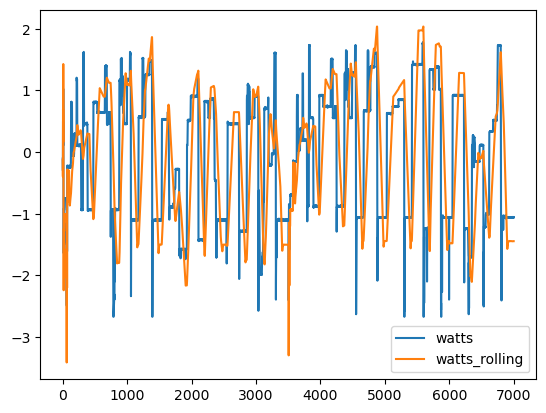

In [ ]:
df_test_scaled[["watts", "watts_rolling"]].reset_index(drop=True).plot()

In [ ]:
window = 60
x_data = []
y_data = []

for i in range(len(df_test)-60-1):
    #x_data.append(df_test_scaled.iloc[i:i+window][["time", "watts", "watts_rolling", "joules"]].values)
    x_data.append(df_test_scaled.iloc[i:i+window][["time", "watts", "watts_rolling"]].values)
    y_data.append(df_test_scaled.iloc[i+window+1]["heartrate"])

In [ ]:
x_data = np.array(x_data)
print(x_data.shape)
y_data = np.array(y_data)
print(y_data.shape)

(6940, 60, 3)
(6940,)


In [ ]:
x_train = x_data[:int(0.8*len(x_data))]
y_train = y_data[:int(0.8*len(y_data))]
x_test = x_data[int(0.8*len(x_data)):]
y_test = y_data[int(0.8*len(y_data)):]

print(x_train.shape)
x_train.mean(axis=2).shape



(5552, 60, 3)


(5552, 60)

In [ ]:
# only needed if one "channel" such as watts is used
if len(x_train.shape) == 2:
    x_train = torch.from_numpy(x_train).float().unsqueeze(2)
    x_test = torch.from_numpy(x_test).float().unsqueeze(2)
    y_train = torch.from_numpy(y_train).float()
    y_test = torch.from_numpy(y_test).float()
else:
    x_train = torch.from_numpy(x_train).float()
    x_test = torch.from_numpy(x_test).float()
    y_train = torch.from_numpy(y_train).float().unsqueeze(1)
    y_test = torch.from_numpy(y_test).float().unsqueeze(1)



In [ ]:
# use pytorch dataloader to load the data into batches for training and testing 
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
df_hr.activity_id.isin([2677299933]).sum()

0

In [ ]:
def generic_loader(activity_id, cols, mean, std, window_size) -> torch.utils.data.DataLoader:
    """Load data for a specific activity_id"""
    cond = df_hr.activity_id.isin([activity_id])
    df_test = df_hr[cond].copy()
    df_test = df_test[cols + ["heartrate"]].copy()
    df_test.dropna(subset=["watts", "heartrate"], inplace=True)
    df_test_scaled = (df_test - mean) / std
    x_data = []
    y_data = []
    for i in range(len(df_test)-window_size-1):
        x_data.append(df_test_scaled.iloc[i:i+window_size][cols].values)
        y_data.append(df_test_scaled.iloc[i+window_size+1]["heartrate"])
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    x_data = torch.from_numpy(x_data).float()
    y_data = torch.from_numpy(y_data).float().unsqueeze(1)
    test_data = torch.utils.data.TensorDataset(x_data, y_data)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
    return test_loader
    

In [ ]:
# create a function for the data loader and the data preparation using a dictionary variable for the columns to use 
# and the number of time steps to use
# the function returns the data loader and the number of features
# the function also returns the mean and standard deviation of the training data
def get_data_loader(cols, window_size, batch_size=32) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, int, float, float]:
    df_scaled = df_test[cols + ["heartrate"]].copy()
    df_scaled_test = df_test2[cols + ["heartrate"]].copy()
    mean_ = df_scaled.iloc[:int(0.8*len(df_scaled))].mean()
    std_ = df_scaled.iloc[:int(0.8*len(df_scaled))].std()
    df_scaled = (df_scaled - mean_) / std_
    df_scaled_test = (df_scaled_test - mean_) / std_
    
    x_data = []
    y_data = []
    for i in range(len(df_scaled) - window_size - 1):
        x_data.append(df_scaled.iloc[i:i+window_size][cols].values)
        y_data.append(df_scaled.iloc[i+window_size+1]["heartrate"])
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    
    x_test_data = []
    y_test_data = []
    for i in range(len(df_scaled_test) - window_size - 1):
        x_test_data.append(df_scaled_test.iloc[i:i+window_size][cols].values)
        y_test_data.append(df_scaled_test.iloc[i+window_size+1]["heartrate"])
    x_test = np.array(x_test_data)
    y_test = np.array(y_test_data)

    x_train = x_data[:int(0.8*len(x_data))]
    y_train = y_data[:int(0.8*len(y_data))]
    x_val = x_data[int(0.8*len(x_data)):]
    y_val = y_data[int(0.8*len(y_data)):]
    
    x_train = torch.from_numpy(x_train).float()
    x_val = torch.from_numpy(x_val).float()
    x_test = torch.from_numpy(x_test).float()
    y_train = torch.from_numpy(y_train).float().unsqueeze(1)
    y_val = torch.from_numpy(y_val).float().unsqueeze(1)
    y_test = torch.from_numpy(y_test).float().unsqueeze(1)
    
    train_data = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data = torch.utils.data.TensorDataset(x_val, y_val)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_data = torch.utils.data.TensorDataset(x_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, len(cols), mean_, std_    

In [ ]:
# define the model
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, batch_size):
        super(Model, self).__init__()
        self.num_layers = layer_size
        self.bs = batch_size
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size, self.num_layers, batch_first=True)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, 1)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.bs, self.hidden_size),
                torch.zeros(self.num_layers, self.bs, self.hidden_size))
    
    def forward(self, input):
        #lstm_out, self.hidden = self.lstm(input.view(len(input), 1, -1), self.hidden)
        #lstm_out, self.hidden = self.lstm(input, self.hidden)
        lstm_out, _ = self.lstm(input)
        lstm_out = self.linear2(lstm_out[:,-1])
        # do relu
        lstm_out = torch.nn.functional.relu(lstm_out)
        #y_pred = self.linear(lstm_out[:,-1])
        y_pred = self.linear(lstm_out)
        return y_pred

# define the model
n_channels = x_train.shape[-1]
model = Model(n_channels, 16, 2, 32)

#wandb.watch(model, log_freq=100)
# print the number of parameters in the model 
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

print(model)
# define the loss function
criterion = torch.nn.MSELoss()
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_result = []
loss_result_val = []

# train the model
epochs = 20
for epoch in range(epochs):
    loss_train = 0
    loss_val = 0
    for x, y in train_loader:
        # forward pass
        y_pred = model(x)
        # calculate the loss
        loss = criterion(y_pred, y)
        # clear the gradients
        optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update the parameters
        optimizer.step()

        loss_train += loss.item()

    # test on the test data using inference mode
    with torch.no_grad():
        for x, y in test_loader:
            # forward pass
            y_pred = model(x)
            # calculate the loss
            loss = criterion(y_pred, y)

            loss_val += loss.item()


    #wandb.log({"loss_train": loss_train/len(train_loader), "loss_val": loss_val/len(test_loader), "epoch": epoch})

    # save the loss
    loss_result.append(loss_train/len(train_loader))
    loss_result_val.append(loss_val/len(test_loader))
    # print the loss
    print(f'epoch: {epoch}, train_loss: {loss_train/len(train_loader)}, val_loss: {loss_val/len(test_loader)}')

NameError: name 'x_train' is not defined

In [331]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print out the device being used with text 
print(f"Using device: {device}")

# set pytorch seeds for reproducibility 
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)

config = dict(
    epochs=10,
    #kernels=[16, 32],
    batch_size=32,
    learning_rate=0.001,
    dataset="strava",
    architecture="conv1d+LSTM+FC",
    bidirectional=True,
    
    window_size=60,
    input_variables=["time", "watts"],#, "watts_rolling"],
    hidden_size=16,
    layer_size=1,

    use_conv1d=False,
    conv_out_size=30,
    )

class Model(torch.nn.Module):
    #def __init__(self, input_size, hidden_size, layer_size, batch_size, conv_out_size="", use_conv1d=False, bidirectional=False):
    def __init__(self, input_size, config):
        super(Model, self).__init__()
        self.num_layers = config.layer_size
        self.bs = config.batch_size
        self.hidden_size = config.hidden_size
        self.conv_out_size = config.conv_out_size
        self.use_conv1d = config.use_conv1d
        self.input_size = input_size
        self.bidirectional = config.bidirectional


        self.lstm = torch.nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.linear2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        # bidirectional need to double the hidden size
        self.linear2_bi_dir = torch.nn.Linear(self.hidden_size*2, self.hidden_size)
        self.linear = torch.nn.Linear(self.hidden_size, 1)
        self.hidden = self.init_hidden()

        self.conv1d_block = torch.nn.Conv1d(self.input_size, self.input_size, self.conv_out_size, stride=1)
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.bs, self.hidden_size),
                torch.zeros(self.num_layers, self.bs, self.hidden_size))
    
    def forward(self, input):
        #lstm_out, self.hidden = self.lstm(input.view(len(input), 1, -1), self.hidden)
        #lstm_out, self.hidden = self.lstm(input, self.hidden)
        if self.use_conv1d:
            # switch from (batch, seq, feature) to (batch, feature, seq) due to conv1d
            input = input.permute(0, 2, 1)
            out = self.conv1d_block(input)
            # swtich from (batch, feature, seq) to (batch, seq, feature) due to lstm
            out = out.permute(0, 2, 1)
            lstm_out, _ = self.lstm(out)
        else:
            lstm_out, _ = self.lstm(input)

        if self.bidirectional:
            lstm_out = self.linear2_bi_dir(lstm_out[:,-1])
        else:
            lstm_out = self.linear2(lstm_out[:,-1])
        # do relu
        lstm_out = torch.nn.functional.relu(lstm_out)
        #y_pred = self.linear(lstm_out[:,-1])
        y_pred = self.linear(lstm_out)
        return y_pred
    

def train(model, train_loader, val_loader, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(train_loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    train_loss_list = []
    val_loss_list = []
    r2_train_list = []
    r2_val_list = []

    for epoch in tqdm(range(config.epochs)):
        train_loss_tot = 0
        r2_tot = 0
        best_loss = np.inf
        for _, (x, y) in enumerate(train_loader):

            loss, r2_train = train_batch(x, y, model, optimizer, criterion)
            example_ct +=  len(x)
            batch_ct += 1
            train_loss_tot += loss.item()
            r2_tot += r2_train

        # Report metrics every 1 epcoh
        if ((epoch + 1) % 1) == 0:
            val_loss_tot = 0
            r2_val_tot = 0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_val_pred = model(x_val)
                    val_loss = criterion(y_val_pred, y_val)
                    val_loss_tot += val_loss.item()
                    # compute r2
                    r2_val = r2_score(y_val.cpu().numpy(), y_val_pred.cpu().numpy())
                    r2_val_tot += r2_val
            
            train_loss_epoch = train_loss_tot/len(train_loader)
            val_loss_epoch = val_loss_tot/len(val_loader)
            train_loss_list.append(train_loss_epoch)
            val_loss_list.append(val_loss_epoch)
            r2_train_epoch = r2_tot/len(train_loader)
            r2_val_epoch = r2_val_tot/len(val_loader)
            r2_train_list.append(r2_train_epoch)
            r2_val_list.append(r2_val_epoch)

            train_log(train_loss_epoch, val_loss_epoch, example_ct, epoch, r2_train_epoch, r2_val_epoch)

        # log best loss value to wandb
        if val_loss_epoch < best_loss:
            best_loss = val_loss_epoch
            wandb.run.summary["best_val_loss"] = best_loss
        
        # make callback to save the best model
        #if val_loss_epoch < best_loss:
        #    config.best_loss = val_loss_epoch
        #    torch.save(model.state_dict(), config.model_path)
        #    print("model saved")
    
    results = {
        "train_loss": train_loss_list,
        "val_loss": val_loss_list,
        "r2_train": r2_train_list,
        "r2_val": r2_val_list
        }
    return results

def train_batch(x, y, model, optimizer, criterion):
    x, y = x.to(device), y.to(device)
    
    # Forward pass ➡
    outputs = model(x)
    loss = criterion(outputs, y)
    # compute r2
    r2 = r2_score(y.cpu().detach().numpy(), outputs.cpu().detach().numpy())
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss, r2

def train_log(loss, val_loss, example_ct, epoch, r2_train, r2_val):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss, "val_loss": val_loss, "r2_train": r2_train, "r2_val":r2_val}, step=example_ct)
    print(f"Epoch: {epoch}, train loss: {loss:.3f}, val loss: {val_loss:.3f}, r2_train: {r2_train:.3f}, r2_val: {r2_val:.3f}")


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader


def make(config):
    # Make the data
    #train, test = get_data(train=True), get_data(train=False)
    #train_loader = make_loader(train, batch_size=config.batch_size)
    #test_loader = make_loader(test, batch_size=config.batch_size)

    train_loader, val_loader, test_loader, input_size, mean, std = (
        get_data_loader(
            cols=config.input_variables, 
            window_size=config.window_size, 
            batch_size=config.batch_size
            )
        )

    # Make the model
    input_size = len(config.input_variables)
    #model = Model(input_size, config.hidden_size, config.layer_size, config.batch_size).to(device)
    model = Model(input_size, config).to(device)

    # Make the loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.learning_rate
        )
    
    return model, train_loader, val_loader, criterion, optimizer, mean, std


def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="strava_predict_full_hr", config=hyperparameters, entity="jerker"):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, val_loader, criterion, optimizer, mean, std = make(config)
      print(model)

      # and use them to train the model
      losses = train(model, train_loader, val_loader, criterion, optimizer, config)

      # and test its final performance
      #test(model, test_loader)

    return model, losses, mean, std

Using device: cpu


In [332]:
model, losses, mean, std = model_pipeline(config)

Model(
  (lstm): LSTM(2, 16, batch_first=True, bidirectional=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear2_bi_dir): Linear(in_features=32, out_features=16, bias=True)
  (linear): Linear(in_features=16, out_features=1, bias=True)
  (conv1d_block): Conv1d(2, 2, kernel_size=(30,), stride=(1,))
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, train loss: 0.552, val loss: 0.135, r2_train: 0.499, r2_val: -30.760
Epoch: 1, train loss: 0.475, val loss: 0.147, r2_train: 0.587, r2_val: -39.079
Epoch: 2, train loss: 0.452, val loss: 0.172, r2_train: 0.610, r2_val: -41.266
Epoch: 3, train loss: 0.454, val loss: 0.133, r2_train: 0.611, r2_val: -30.142
Epoch: 4, train loss: 0.450, val loss: 0.139, r2_train: 0.624, r2_val: -32.568
Epoch: 5, train loss: 0.452, val loss: 0.105, r2_train: 0.612, r2_val: -23.145
Epoch: 6, train loss: 0.444, val loss: 0.104, r2_train: 0.636, r2_val: -24.417
Epoch: 7, train loss: 0.438, val loss: 0.104, r2_train: 0.640, r2_val: -25.827
Epoch: 8, train loss: 0.433, val loss: 0.143, r2_train: 0.641, r2_val: -31.118
Epoch: 9, train loss: 0.431, val loss: 0.117, r2_train: 0.642, r2_val: -26.889


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▂▂▂▁▁▁
r2_train,▁▅▆▆▇▇████
r2_val,▅▂▁▅▄██▇▅▇
val_loss,▄▅█▄▅▁▁▁▅▂
epoch,9
loss,0.43096
r2_train,0.64215
r2_val,-26.88923
val_loss,0.11722


In [ ]:
# use namedtuple to get attributes for a dictionary
from collections import namedtuple

config2 = namedtuple("config2", config.keys())(*config.values())
# define new model with same hyperparameters as before and load weights from wandb run 
model2 = Model(2, config2).to(device)
model2.load_state_dict(model.state_dict())


<All keys matched successfully>

In [ ]:
def plot_predictions(activity_id, config, mean, std):
    # call generic_loader with 2677299933 as the activity id to get the data for that activity
    test_loader = generic_loader(activity_id, config["input_variables"], mean, std, config["window_size"])

    # use the model to predict the heart rate for the test loader
    preds = []
    y_test_data = []
    # do inference and turn off wandb

    model2.eval()
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            y_test_pred = model2(x_test)
            preds.append(y_test_pred.cpu().numpy())
            # add y_test to a list to plot later
            y_test_data.append(y_test.cpu().numpy())

    preds = np.array(preds)
    y_test_data = np.array(y_test_data)
    preds = preds.reshape(-1,1)
    y_test_data = y_test_data.reshape(-1,1)
    preds = preds * std.heartrate + mean.heartrate
    y_test_data = y_test_data * std.heartrate + mean.heartrate

    # compute r2 and rmse
    r2 = r2_score(y_test_data, preds)
    rmse = np.sqrt(mean_squared_error(y_test_data, preds))
    # make subplots with two graphs
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    # plot the predictions and the real heart rate
    ax[0].plot(preds, label="pred")
    ax[0].plot(y_test_data, label="real")
    # limit y-axis between 100 and 180
    ax[0].set_ylim(100, 180)
    ax[0].legend()

    # get the data for the activity_id from df_hr and plot the watts and time on the second graph 
    df_temp = df_hr[df_hr.activity_id == activity_id].copy()
    ax[1].plot(df_temp.time, df_temp.watts)
    ax[1].set_ylabel("Watts")
    ax[1].set_xlabel("Time")

    # add rmse and r2 to the title
    ax[0].set_title(f"RMSE: {rmse:.2f}, R2: {r2:.2f}")
    plt.show()


    # plot the predictions and the real heart rate
    #plt.plot(preds, label="pred")
    #plt.plot(y_test_data, label="real")
    # limit y-axis between 100 and 180
    #plt.ylim(100, 180)
    #plt.legend()
    #plt.show()





In [ ]:
nine_hammers_activities

[8031217762,
 7734676869,
 7119038757,
 7029385134,
 6722790718,
 6103753599,
 5269621743,
 4057964600,
 3466480442,
 3418305919,
 3379261884,
 3357980775,
 3241849794,
 3126326839,
 3086063316,
 3065631046,
 3045837646,
 3025153587,
 3004307546,
 2987119442,
 2677299933]

In [ ]:
m = nn.Conv1d(in_channels=4, out_channels=4, kernel_size=120, stride=1)
input = torch.randn(10, 4, 200)
output = m(input)
print(output.shape)

torch.Size([10, 4, 81])


In [ ]:
output.shape

torch.Size([10, 4, 81])

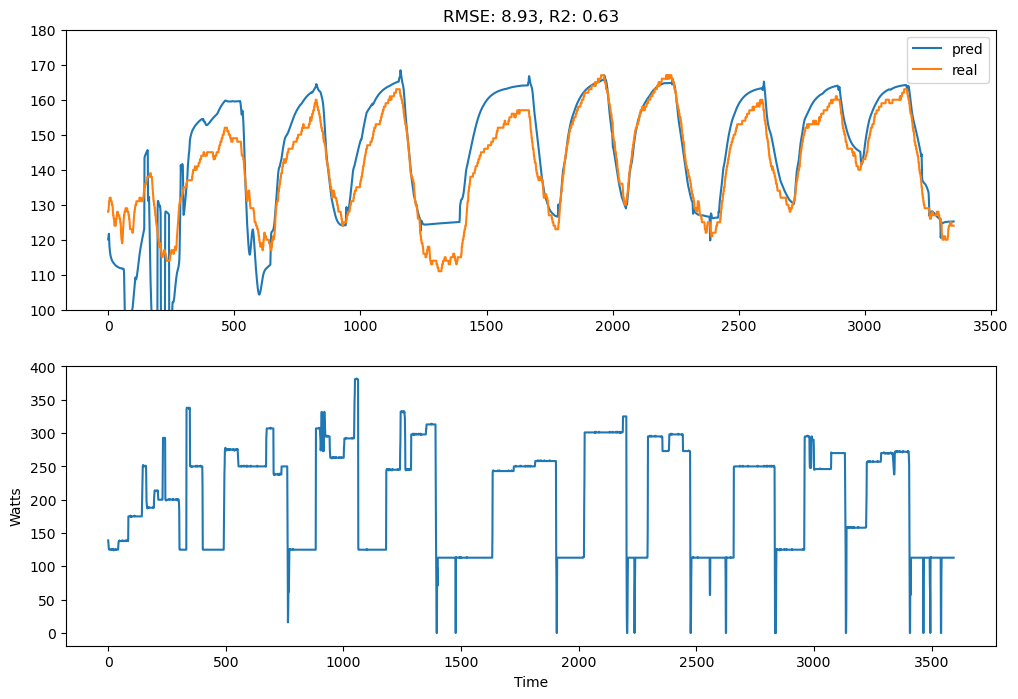

In [ ]:
plot_predictions(2987119442, config, mean, std)

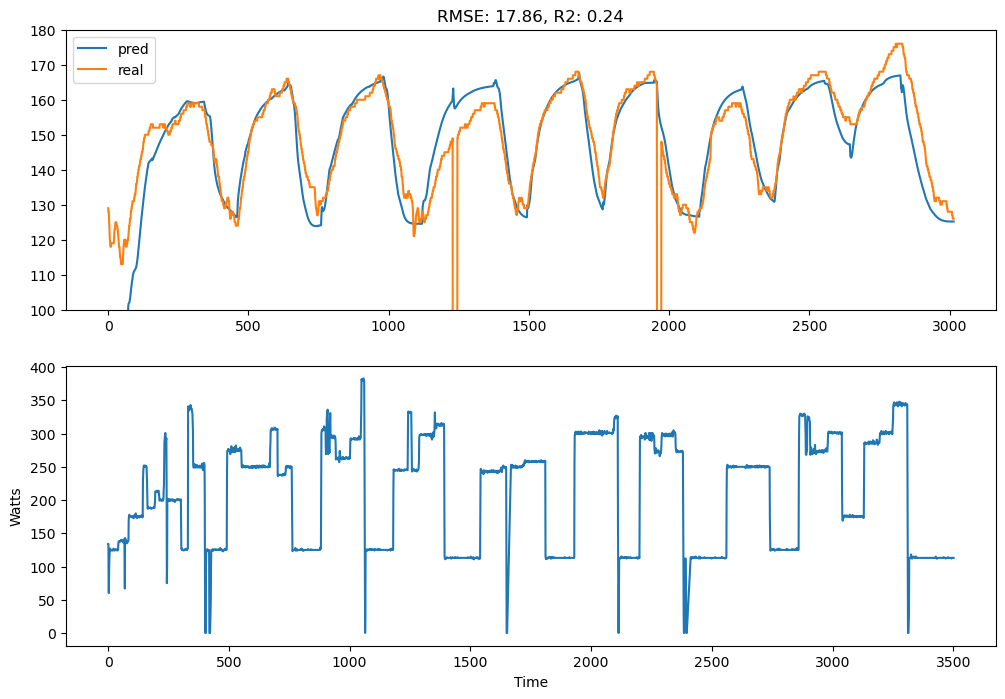

In [ ]:
plot_predictions(2677299933, config, mean, std)

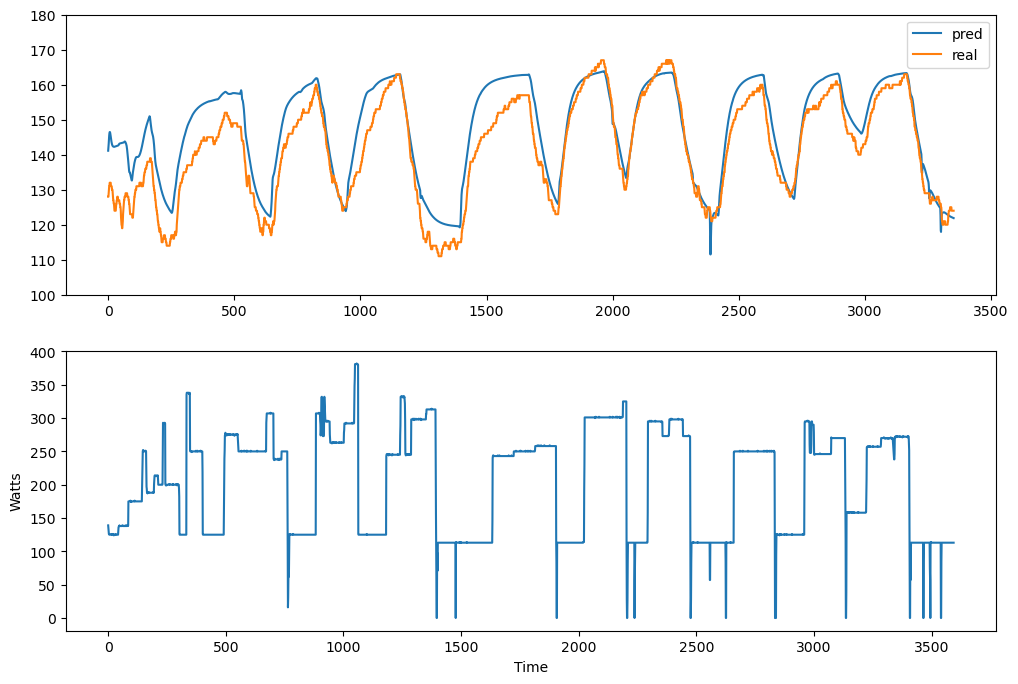

In [ ]:
plot_predictions(2987119442, config, mean, std)

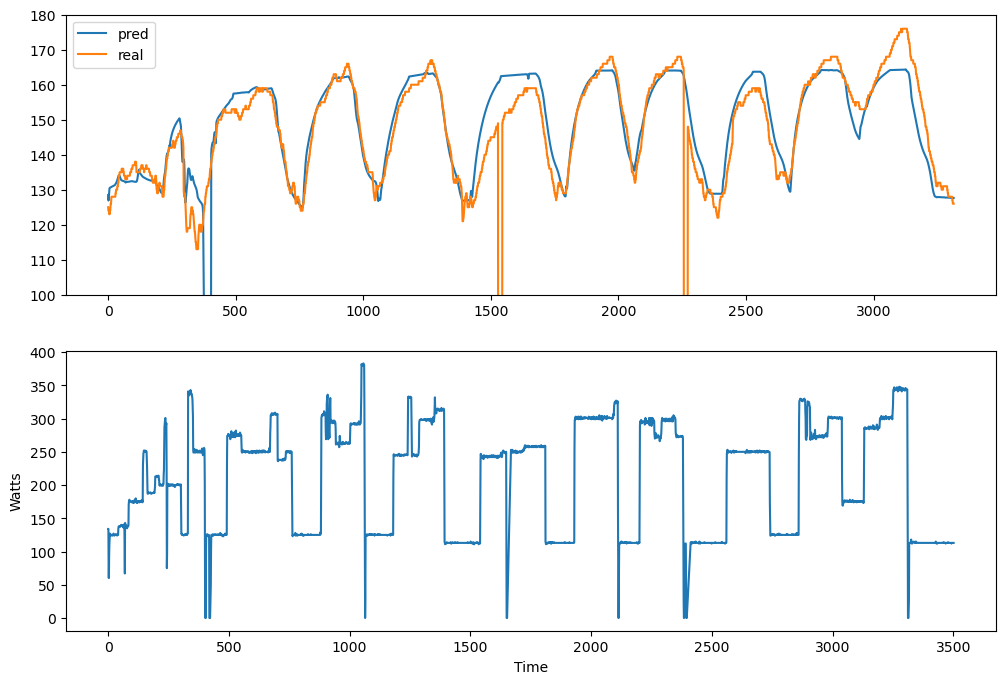

In [ ]:
plot_predictions(2677299933, config, mean, std)

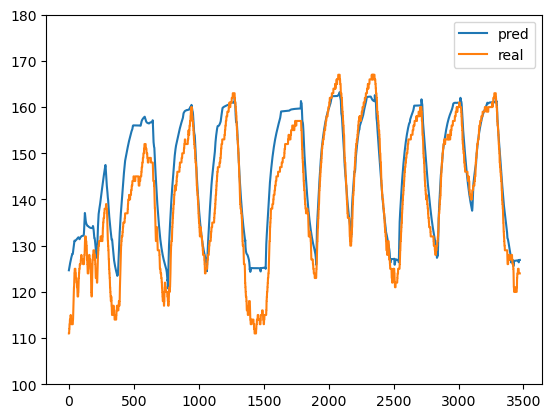

In [ ]:
plot_predictions(2987119442, config, mean, std)

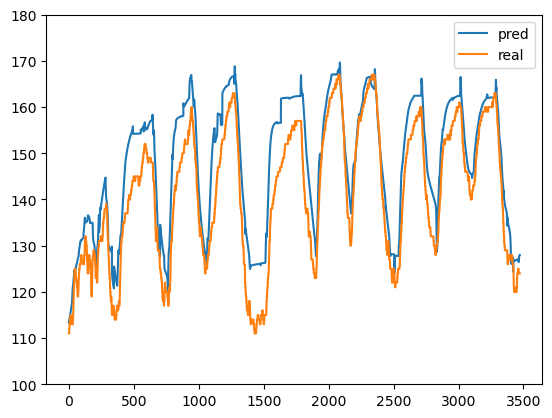

In [ ]:
plot_predictions(2987119442, config, mean, std)

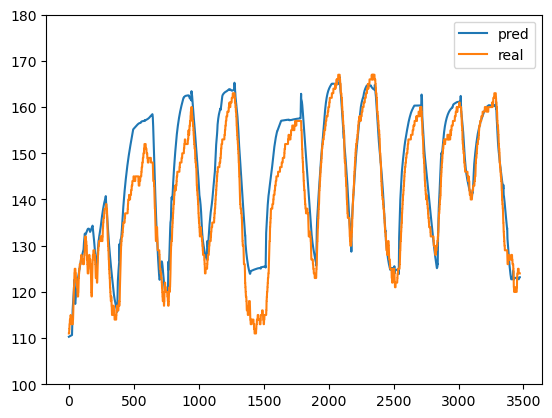

In [ ]:
plot_predictions(2987119442, config, mean, std)

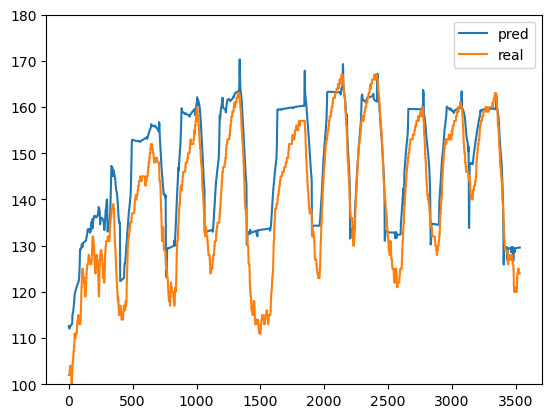

In [ ]:
plot_predictions(2987119442, config, mean, std)

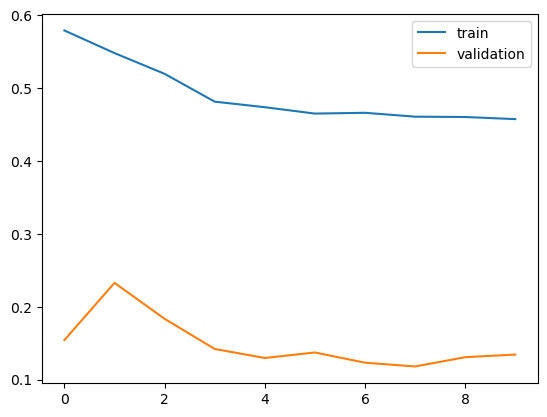

In [ ]:
# plot the train and validation loss
plt.plot(losses["train_loss"], label="train")
plt.plot(losses["val_loss"], label="validation")
plt.legend()
plt.show()


In [ ]:
# import torchinfo and print the model summary
from torchinfo import summary
summary(model, input_size=(config["batch_size"], config["window_size"], len(config["input_variables"])))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 1]                   --
├─LSTM: 1-1                              [32, 60, 8]               384
├─Linear: 1-2                            [32, 8]                   72
├─Linear: 1-3                            [32, 1]                   9
Total params: 465
Trainable params: 465
Non-trainable params: 0
Total mult-adds (M): 0.74
Input size (MB): 0.02
Forward/backward pass size (MB): 0.13
Params size (MB): 0.00
Estimated Total Size (MB): 0.14

In [ ]:
# make predictions with the model on the train and test data    
y_train_pred = model(x_train)
y_test_pred = model(x_test)

y_train_pred = y_train_pred.detach().numpy() * std_["heartrate"] + mean_["heartrate"]
y_test_pred = y_test_pred.detach().numpy() * std_["heartrate"] + mean_["heartrate"]

y_train2 = y_train * std_["heartrate"] + mean_["heartrate"]
y_test2 = y_test * std_["heartrate"] + mean_["heartrate"]


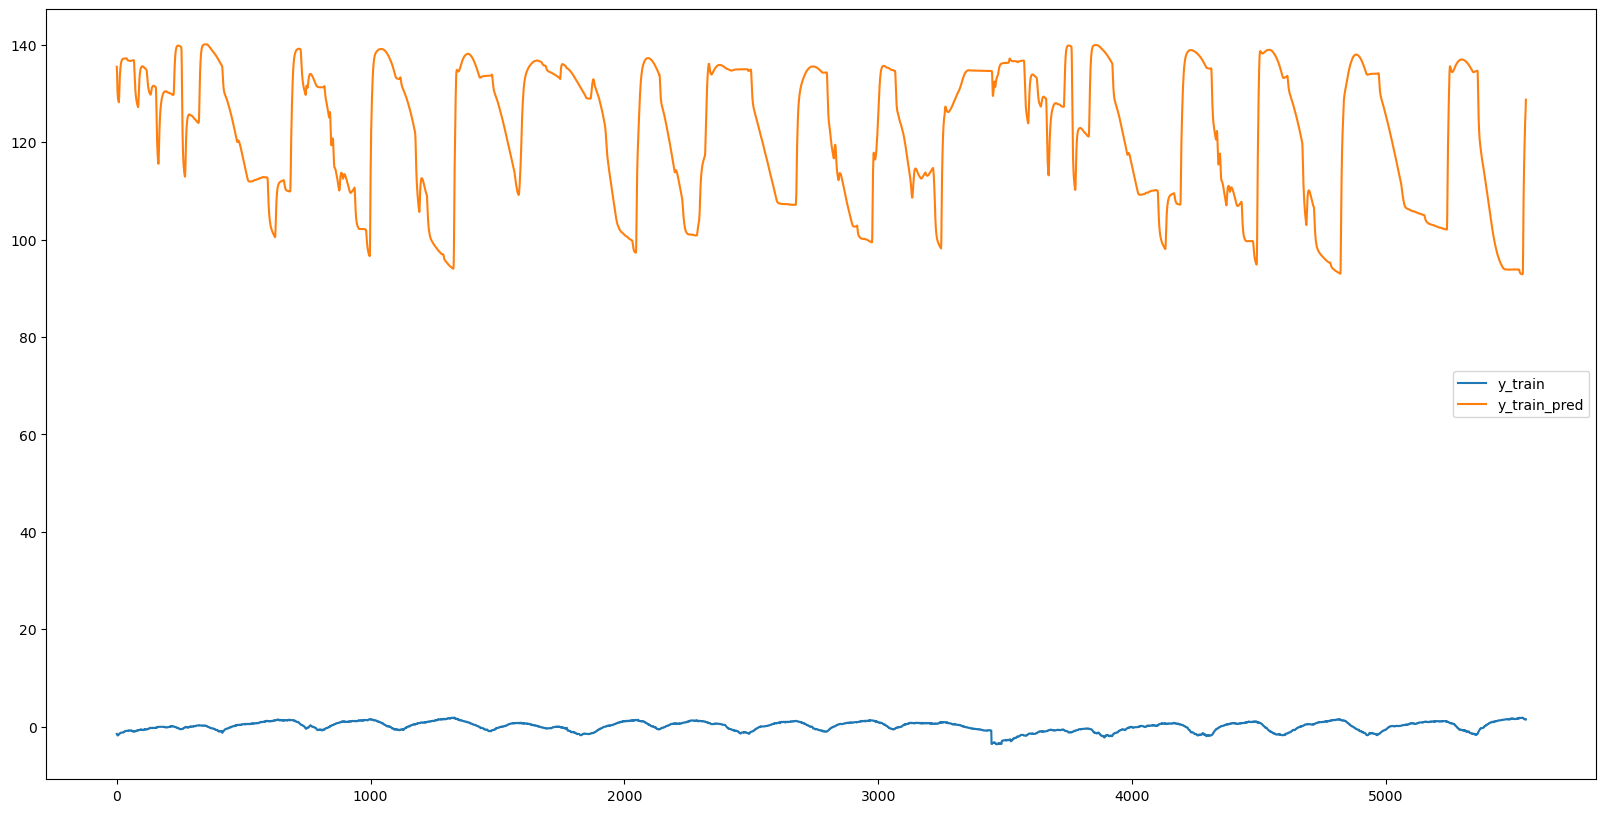

In [ ]:
# plot y_train and y_train_pred and y_test and y_test_predwith the correct x-axis values
plt.figure(figsize=(20,10))
#plt.plot(df_test.iloc[window+1:window+1+len(y_train)]["time"].values.reshape(-1,1), y_train2, label="y_train")
#plt.plot(df_test.iloc[window+1:window+1+len(y_train)]["time"].values.reshape(-1,1), y_train_pred, label="y_train_pred")
plt.plot(y_train, label="y_train")
plt.plot(y_train_pred, label="y_train_pred")

#plt.plot(df_test.iloc[window+1+len(y_train):]["time"].values.reshape(-1,1), y_test2, label="y_test")
#plt.plot(df_test.iloc[window+1+len(y_train):]["time"].values.reshape(-1,1), y_test_pred, label="y_test_pred")
plt.legend()
plt.show()


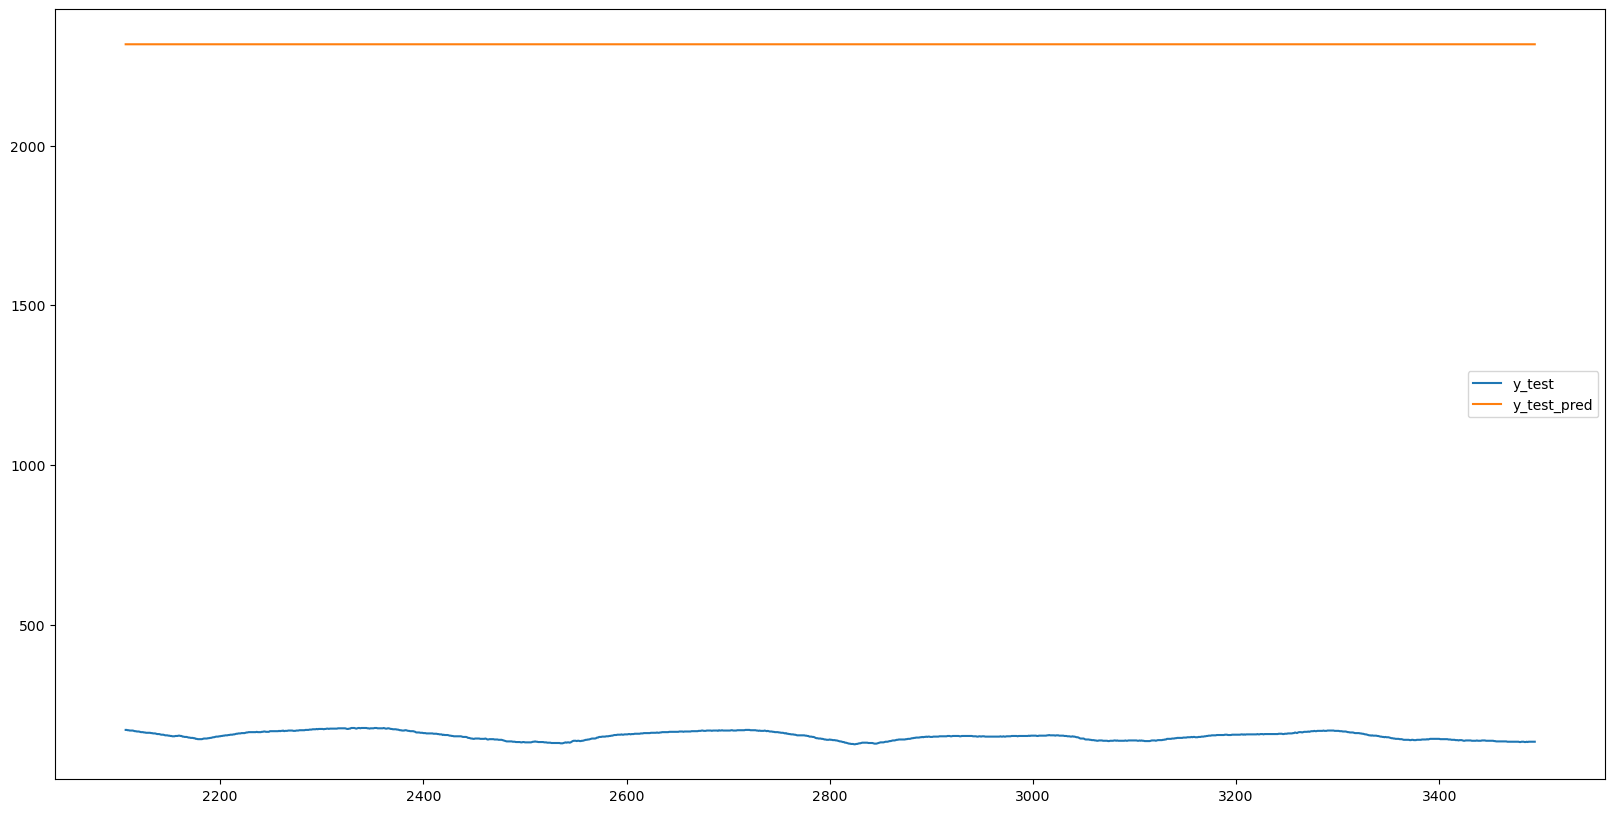

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df_test.iloc[window+1+len(y_train):]["time"].values.reshape(-1,1), y_test2, label="y_test")
plt.plot(df_test.iloc[window+1+len(y_train):]["time"].values.reshape(-1,1), y_test_pred, label="y_test_pred")
plt.legend()
plt.show()

In [ ]:
seq_len = 200
bs = 64
num_layers = 1
input_size=1
hidden_size=50

X = torch.rand(bs, seq_len, input_size)

hidden = (torch.zeros(num_layers, bs, hidden_size), torch.zeros(num_layers, bs, hidden_size))

lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

In [ ]:
lstm(X)[0].shape

torch.Size([64, 200, 50])

In [ ]:
a, b = lstm(X, hidden)
print(X.shape)
print(hidden[0].shape)
print(a.shape)
print(b[0].shape)

torch.Size([64, 200, 1])
torch.Size([1, 64, 50])
torch.Size([64, 200, 50])
torch.Size([1, 64, 50])


In [ ]:
dict(lstm.named_parameters()).keys()

dict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0', 'weight_ih_l1', 'weight_hh_l1', 'bias_ih_l1', 'bias_hh_l1', 'weight_ih_l2', 'weight_hh_l2', 'bias_ih_l2', 'bias_hh_l2', 'weight_ih_l3', 'weight_hh_l3', 'bias_ih_l3', 'bias_hh_l3', 'weight_ih_l4', 'weight_hh_l4', 'bias_ih_l4', 'bias_hh_l4', 'weight_ih_l5', 'weight_hh_l5', 'bias_ih_l5', 'bias_hh_l5', 'weight_ih_l6', 'weight_hh_l6', 'bias_ih_l6', 'bias_hh_l6', 'weight_ih_l7', 'weight_hh_l7', 'bias_ih_l7', 'bias_hh_l7', 'weight_ih_l8', 'weight_hh_l8', 'bias_ih_l8', 'bias_hh_l8', 'weight_ih_l9', 'weight_hh_l9', 'bias_ih_l9', 'bias_hh_l9', 'weight_ih_l10', 'weight_hh_l10', 'bias_ih_l10', 'bias_hh_l10', 'weight_ih_l11', 'weight_hh_l11', 'bias_ih_l11', 'bias_hh_l11', 'weight_ih_l12', 'weight_hh_l12', 'bias_ih_l12', 'bias_hh_l12', 'weight_ih_l13', 'weight_hh_l13', 'bias_ih_l13', 'bias_hh_l13', 'weight_ih_l14', 'weight_hh_l14', 'bias_ih_l14', 'bias_hh_l14', 'weight_ih_l15', 'weight_hh_l15', 'bias_ih_l15', 'bias_hh_l15', 'weig

In [ ]:
# import pytorch lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer

In [ ]:
# use pytorch_lightning lstm model to predict heartrate based on watts and cadence
from pytorch_lightning.metrics.functional import r2score
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# import sklearn
from sklearn.preprocessing import StandardScaler


In [ ]:
import torch
sentence = torch.tensor(
    [0,
    7,
    1,
    2,
    5,
    6,
    4,
    3]
)

print(sentence)

tensor([0, 7, 1, 2, 5, 6, 4, 3])


In [ ]:
torch.manual_seed(123)
embed = torch.nn.Embedding(10, 16)
embedded_sentence = embed(sentence).detach()
#print(embedded_sentence)
print(embedded_sentence.shape)

torch.Size([8, 16])


In [ ]:
omega = torch.empty(8,8)
for i, x_i in enumerate(embedded_sentence):
    for j, x_j in enumerate(embedded_sentence):
        omega[i,j] = torch.dot(x_i, x_j)

In [ ]:
omega_mat = embedded_sentence.matmul(embedded_sentence.T)

In [ ]:
import torch.nn.functional as F
attention_weights = F.softmax(omega, dim=1)
print(attention_weights.shape)

torch.Size([8, 8])


In [ ]:
x_2 = embedded_sentence[1,:]
context_vec_2 = torch.zeros(x_2.shape)
for j in range(8):
    x_j = embedded_sentence[j,:]
    context_vec_2 += attention_weights[1,j] * x_j
print(context_vec_2)

tensor([-9.3975e-01, -4.6856e-01,  1.0311e+00, -2.8192e-01,  4.9373e-01,
        -1.2896e-02, -2.7327e-01, -7.6358e-01,  1.3958e+00, -9.9543e-01,
        -7.1287e-04,  1.2449e+00, -7.8077e-02,  1.2765e+00, -1.4589e+00,
        -2.1601e+00])


In [ ]:
context_vectors = torch.matmul(attention_weights, embedded_sentence)

In [ ]:
d = embedded_sentence.shape[1]
print(d)
U_query = torch.randn(d, d)
U_key = torch.randn(d, d)
U_value = torch.randn(d, d)

x_2 = embedded_sentence[1,:]
print(x_2.shape)
query_2 = U_query.matmul(x_2)
print(query_2.shape)

key_2 = U_key.matmul(x_2)
value_2 = U_value.matmul(x_2)

keys = U_key.matmul(embedded_sentence.T).T
values = U_value.matmul(embedded_sentence.T).T

16
torch.Size([16])
torch.Size([16])


In [ ]:
omega_23 = query_2.dot(keys[2])
omega_23

tensor(-227.7193)

In [ ]:
omega_2 = query_2.matmul(keys.T)
omega_2

tensor([ -27.4746,  -69.3855, -227.7193,    7.6392,  -63.0225,    8.0977,
          -7.1507,  -48.4587])

In [ ]:
omega_2 / d**0.5

tensor([ -6.8686, -17.3464, -56.9298,   1.9098, -15.7556,   2.0244,  -1.7877,
        -12.1147])

In [ ]:
F.softmax(omega_2 , dim=0)

tensor([2.1795e-16, 1.3698e-34, 0.0000e+00, 3.8734e-01, 7.9449e-32, 6.1266e-01,
        1.4619e-07, 1.6790e-25])

In [ ]:
attention_weights_2 = F.softmax(omega_2 / d**0.5 , dim=0)
print(attention_weights_2.sum(dim=0))
attention_weights_2

tensor(1.0000)


tensor([7.1756e-05, 2.0204e-09, 1.3019e-26, 4.6590e-01, 9.9149e-09, 5.2248e-01,
        1.1548e-02, 3.7803e-07])

In [ ]:
context_vector_2 = attention_weights_2.matmul(values)
context_vector_2

tensor([ 2.3713, -0.1583, -1.0061,  7.7921,  6.6322, -2.5136, -1.9096, -1.1220,
         0.9517, -6.8023,  1.1373,  6.3096, -3.7652,  4.6426,  4.9339,  2.3610])

In [ ]:
# create a class for the dataset to be used in the pytorch lightning model 
class HeartrateDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.scaler.fit(self.df)
        self.df = self.scaler.transform(self.df)
        self.df = torch.from_numpy(self.df).float()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        return self.df[idx, :-1], self.df[idx, -1]



In [ ]:

# use pytorch lightning lstm model to predict heartrate based on watts and cadence
class HeartratePrediction(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size, lr=0.001, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.batch_size = batch_size
        self.lr = lr
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.input_size = input_size
        self.h0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        self.c0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        
    def forward(self, x):
        out, _ = self.lstm(x, (self.h0, self.c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('test_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = HeartrateDataset(self.hparams, 'train')
            self.val_dataset = HeartrateDataset(self.hparams


# Predict with lgbm

In [502]:
# import lightbm regressor to predict heartrate based on watts and cadence
from lightgbm import LGBMRegressor
# import train_test_split
from sklearn.model_selection import train_test_split
# train lightgbm regressor
lgbm = LGBMRegressor()
# compute r2, rmse and mae on train, val and test set
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [503]:
# make training and predict on train, val and test set and print r2, rmse and mae
def train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features):

    # predict heartrate on train, val and test set
    y_train_pred = lgbm.predict(X_train)
    y_val_pred = lgbm.predict(X_val)
    y_test_pred = lgbm.predict(X_test)

    # wrap the below in a function to make it reusable for other models as well 

    print(f"Features: {features}")
    print(f"Train R2: {r2_score(y_train, y_train_pred):.2f}, Train RMSE: {mean_squared_error(y_train, y_train_pred, squared=False):.2f}, Train MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
    print(f"Val R2: {r2_score(y_val, y_val_pred):.2f}, Val RMSE: {mean_squared_error(y_val, y_val_pred, squared=False):.2f}, Val MAE: {mean_absolute_error(y_val, y_val_pred):.2f}")
    print(f"Test R2: {r2_score(y_test, y_test_pred):.2f}, Test RMSE: {mean_squared_error(y_test, y_test_pred, squared=False):.2f}, Test MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")

In [598]:
df_test3 = df_test.copy()

# groupby activity_id caluclate rolling mean of watts and cadence
df_test3['watts_rolling_mean_60s'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: x.rolling(60, 1).mean())
df_test3['watts_rolling_mean_120s'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: x.rolling(120, 1).mean())
df_test3['watts_rolling_mean_180s'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: x.rolling(180, 1).mean())
df_test3['watts_rolling_mean_240s'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: x.rolling(240, 1).mean())
df_test3['watts_rolling_mean_300s'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: x.rolling(300, 1).mean())
df_test3['watts_rolling_mean_360s'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: x.rolling(360, 1).mean())
df_test3['watts_rolling_mean_420s'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: x.rolling(420, 1).mean())

# expanding mean of watts
df_test3['watts_expanding_mean'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: x.expanding().mean())

df_test3.groupby('activity_id')['watts'].transform(lambda x: x.rolling(60, 1).mean())

# calculate new feature how many seconds above a certain threshold
df_test3['watts_above_250'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: (x > 250).astype(int).cumsum())
df_test3['watts_above_300'] = df_test3.groupby('activity_id')['watts'].transform(lambda x: (x > 300).astype(int).cumsum())

df_test3["watts_below_150"] = df_test3["watts"] < 150
df_test3["watts_below_150_shifted"] = df_test3.groupby("activity_id")["watts_below_150"].shift(1).fillna(method="bfill")
df_test3["watts_below_150_changed"] = df_test3["watts_below_150"] != df_test3["watts_below_150_shifted"]
# do a cumsum on the shifted column
df_test3["watts_below_150_shifted_cumsum"] = df_test3.groupby("activity_id")["watts_below_150_changed"].cumsum()
df_test3["time_below_150"] = df_test3.groupby(["activity_id", "watts_below_150_shifted_cumsum"])["watts_below_150"].cumsum()

df_test3["watts_above_300"] = df_test3["watts"] > 300
df_test3["watts_above_300_shifted"] = df_test3.groupby("activity_id")["watts_above_300"].shift(1).fillna(method="bfill")
df_test3["watts_above_300_changed"] = df_test3["watts_above_300"] != df_test3["watts_above_300_shifted"]
# do a cumsum on the shifted column
df_test3["watts_above_300_shifted_cumsum"] = df_test3.groupby("activity_id")["watts_above_300_changed"].cumsum()
df_test3["time_above_300"] = df_test3.groupby(["activity_id", "watts_above_300_shifted_cumsum"])["watts_above_300"].cumsum()

df_test3["watts_above_250"] = df_test3["watts"] > 250
df_test3["watts_above_250_shifted"] = df_test3.groupby("activity_id")["watts_above_250"].shift(1).fillna(method="bfill")
df_test3["watts_above_250_changed"] = df_test3["watts_above_250"] != df_test3["watts_above_250_shifted"]
# do a cumsum on the shifted column
df_test3["watts_above_250_shifted_cumsum"] = df_test3.groupby("activity_id")["watts_above_250_changed"].cumsum()
df_test3["time_above_250"] = df_test3.groupby(["activity_id", "watts_above_250_shifted_cumsum"])["watts_above_250"].cumsum()

# drop rows where heartrate is 0
df_test3 = df_test3[df_test3['heartrate'] != 0]

# merge in general activity data
df_test3 = df_test3.merge(df_full.select_dtypes(include="number"), on="activity_id", how="left")

# drop hearrate if null
df_test3 = df_test3.dropna(subset=['heartrate'])

n_ids = df_test3.activity_id.nunique()
ids = df_test3.activity_id.unique().tolist()

train_ids = ids[:int(n_ids*0.8)]
val_ids = ids[int(n_ids*0.8):int(n_ids*0.9)]
test_ids = ids[int(n_ids*0.9):]

train_df = df_test3[df_test3.activity_id.isin(train_ids)]
val_df = df_test3[df_test3.activity_id.isin(val_ids)]
test_df = df_test3[df_test3.activity_id.isin(test_ids)]


In [599]:
df_test3.head()

,activity_id,time,watts,heartrate,distance_x,velocity_smooth,altitude,cadence,heartrate_missing,hr_eq_0,hr_eq_0_shift1,hr_eq_0_shift_1,hr_eq_0_and_shifted,hr_eq_0_shifted_cumsum,hr_eq_0_shifted_cumsum_count,joules,watts_rolling,watts_rolling_mean_60s,watts_rolling_mean_120s,watts_rolling_mean_180s,watts_rolling_mean_240s,watts_rolling_mean_300s,watts_rolling_mean_360s,watts_rolling_mean_420s,watts_expanding_mean,watts_above_250,watts_above_300,watts_below_150,watts_below_150_shifted,watts_below_150_changed,watts_below_150_shifted_cumsum,time_below_150,watts_above_300_shifted,watts_above_300_changed,watts_above_300_shifted_cumsum,time_above_300,watts_above_250_shifted,watts_above_250_changed,watts_above_250_shifted_cumsum,time_above_250,mean_watts,moving_time,elapsed_time,weighted_mean_watts,elev_gain,kilojoules,average_speed,distance_y,year,hour,moving_time_min,elapsed_time_min,days_since,suffer_score_prev,suffer_score_rolling_mean_7,suffer_score_rolling_std_7,suffer_score_rolling_max_7,suffer_score_rolling_mean_14,suffer_score_rolling_std_14,suffer_score_rolling_max_14,suffer_score_rolling_mean_30,suffer_score_rolling_std_30,suffer_score_rolling_max_30,suffer_score_rolling_mean_60,suffer_score_rolling_std_60,suffer_score_rolling_max_60,suffer_score_rolling_mean_90,suffer_score_rolling_std_90,suffer_score_rolling_max_90,max_hr_rolling_mean_7,max_hr_rolling_std_7,max_hr_rolling_max_7,max_hr_rolling_mean_14,max_hr_rolling_std_14,max_hr_rolling_max_14,max_hr_rolling_mean_30,max_hr_rolling_std_30,max_hr_rolling_max_30,max_hr_rolling_mean_60,max_hr_rolling_std_60,max_hr_rolling_max_60,max_hr_rolling_mean_90,max_hr_rolling_std_90,max_hr_rolling_max_90,mean_hr_rolling_mean_7,mean_hr_rolling_std_7,mean_hr_rolling_max_7,mean_hr_rolling_mean_14,mean_hr_rolling_std_14,mean_hr_rolling_max_14,mean_hr_rolling_mean_30,mean_hr_rolling_std_30,mean_hr_rolling_max_30,mean_hr_rolling_mean_60,mean_hr_rolling_std_60,mean_hr_rolling_max_60,mean_hr_rolling_mean_90,mean_hr_rolling_std_90,mean_hr_rolling_max_90,mean_watts_rolling_mean_7,mean_watts_rolling_std_7,mean_watts_rolling_max_7,mean_watts_rolling_mean_14,mean_watts_rolling_std_14,mean_watts_rolling_max_14,mean_watts_rolling_mean_30,mean_watts_rolling_std_30,mean_watts_rolling_max_30,mean_watts_rolling_mean_60,mean_watts_rolling_std_60,mean_watts_rolling_max_60,mean_watts_rolling_mean_90,mean_watts_rolling_std_90,mean_watts_rolling_max_90,calories_rolling_mean_7,calories_rolling_std_7,calories_rolling_max_7,calories_rolling_mean_14,calories_rolling_std_14,calories_rolling_max_14,calories_rolling_mean_30,calories_rolling_std_30,calories_rolling_max_30,calories_rolling_mean_60,calories_rolling_std_60,calories_rolling_max_60,calories_rolling_mean_90,calories_rolling_std_90,calories_rolling_max_90,moving_time_rolling_mean_7,moving_time_rolling_std_7,moving_time_rolling_max_7,moving_time_rolling_mean_14,moving_time_rolling_std_14,moving_time_rolling_max_14,moving_time_rolling_mean_30,moving_time_rolling_std_30,moving_time_rolling_max_30,moving_time_rolling_mean_60,moving_time_rolling_std_60,moving_time_rolling_max_60,moving_time_rolling_mean_90,moving_time_rolling_std_90,moving_time_rolling_max_90,elapsed_time_rolling_mean_7,elapsed_time_rolling_std_7,elapsed_time_rolling_max_7,elapsed_time_rolling_mean_14,elapsed_time_rolling_std_14,elapsed_time_rolling_max_14,elapsed_time_rolling_mean_30,elapsed_time_rolling_std_30,elapsed_time_rolling_max_30,elapsed_time_rolling_mean_60,elapsed_time_rolling_std_60,elapsed_time_rolling_max_60,elapsed_time_rolling_mean_90,elapsed_time_rolling_std_90,elapsed_time_rolling_max_90,weighted_mean_watts_rolling_mean_7,weighted_mean_watts_rolling_std_7,weighted_mean_watts_rolling_max_7,weighted_mean_watts_rolling_mean_14,weighted_mean_watts_rolling_std_14,weighted_mean_watts_rolling_max_14,weighted_mean_watts_rolling_mean_30,weighted_mean_watts_rolling_std_30,weighted_mean_watts_rolling_max_30,weighted_mean_watts_rolling_mean_60,weighted_mean_watts_rolling_std_60,weighted_m

In [600]:
# train_test_split
features = ["time", "watts", "time_above_250", "time_above_300", "time_below_150", "watts_above_250", "watts_above_300", "watts_expanding_mean", "watts_rolling_mean_60s", "watts_rolling_mean_120s", "watts_rolling_mean_180s", "watts_rolling_mean_240s", "watts_rolling_mean_300s", "watts_rolling_mean_360s", "watts_rolling_mean_420s"]
target = "heartrate"
# use all features except target as features 
features = train_df.drop(columns=[target]).columns.tolist()
# if activity_id is in features, remove it
if "activity_id" in features:
    features.remove("activity_id")

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

# train lightgbm regressor
lgbm = LGBMRegressor(random_state=42)
# fit model
lgbm.fit(X_train, y_train)

LGBMRegressor(random_state=42)

In [507]:
# create a function to plot predicted heartrate and real heartrate for a given activity_id
def plot_activity(lgbm, activity_id):
    # select activity_id
    activity = df_test3[df_test3.activity_id == activity_id]
    
    # make prediction with lightgbm
    y_pred = lgbm.predict(activity[features])

    # plot predicted heartrate and real heartrate
    plt.figure(figsize=(20, 10))
    plt.plot(activity.time, activity.heartrate, label="real heartrate")
    plt.plot(activity.time, y_pred, label="predicted heartrate")
    plt.legend()
    plt.ylim(100, 175)
    plt.show()
    

In [601]:
val_ids

[3126326839,
 3086063316,
 3065631046,
 3045837646,
 3025153587,
 3004307546,
 2987119442,
 2970196545,
 2958065918]

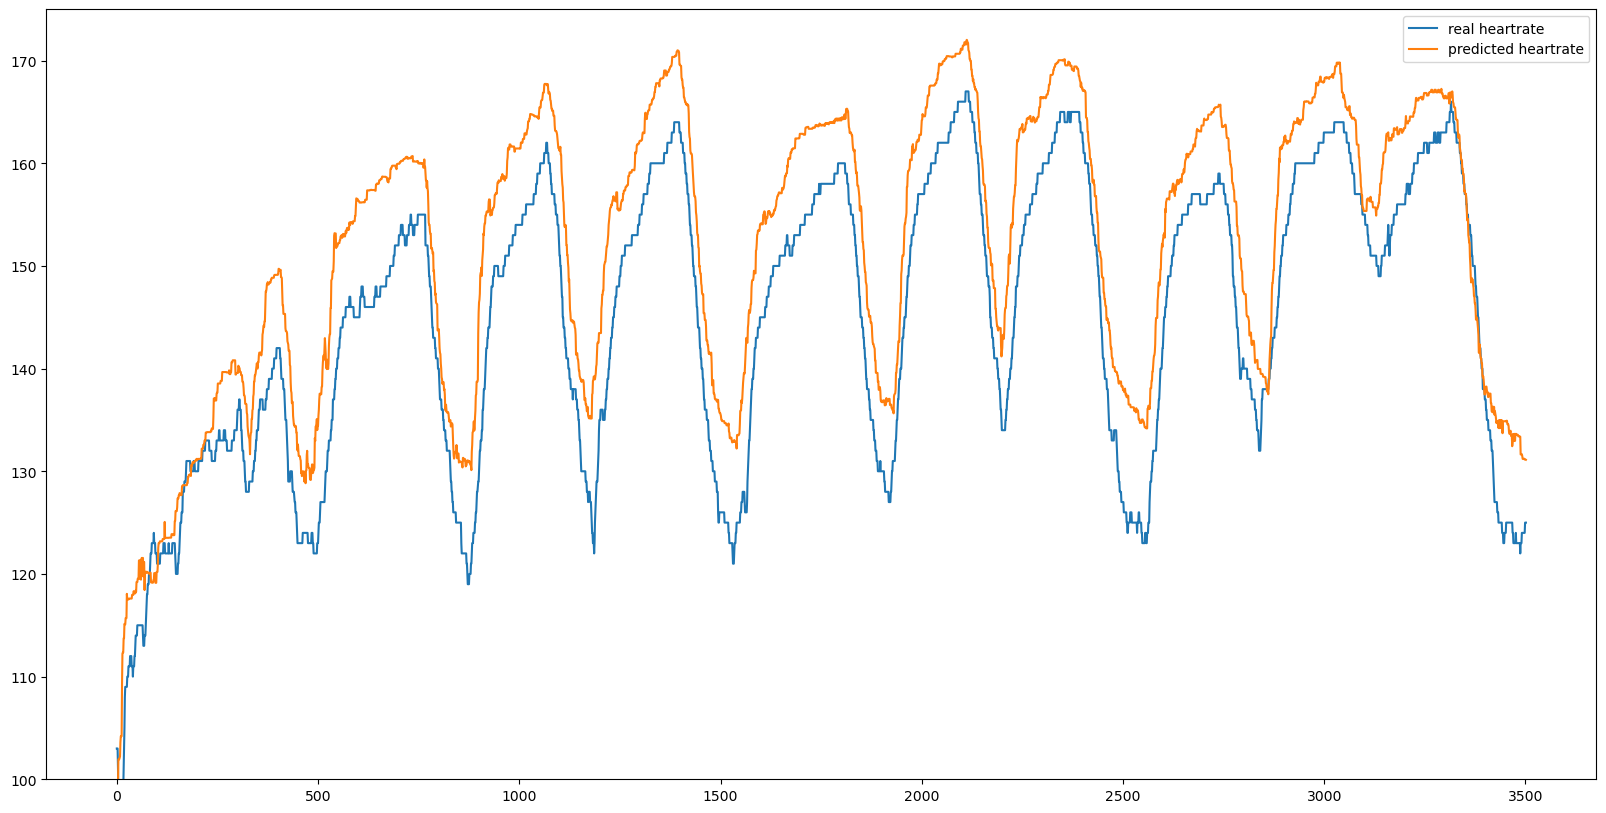

In [602]:
plot_activity(lgbm, 3025153587)

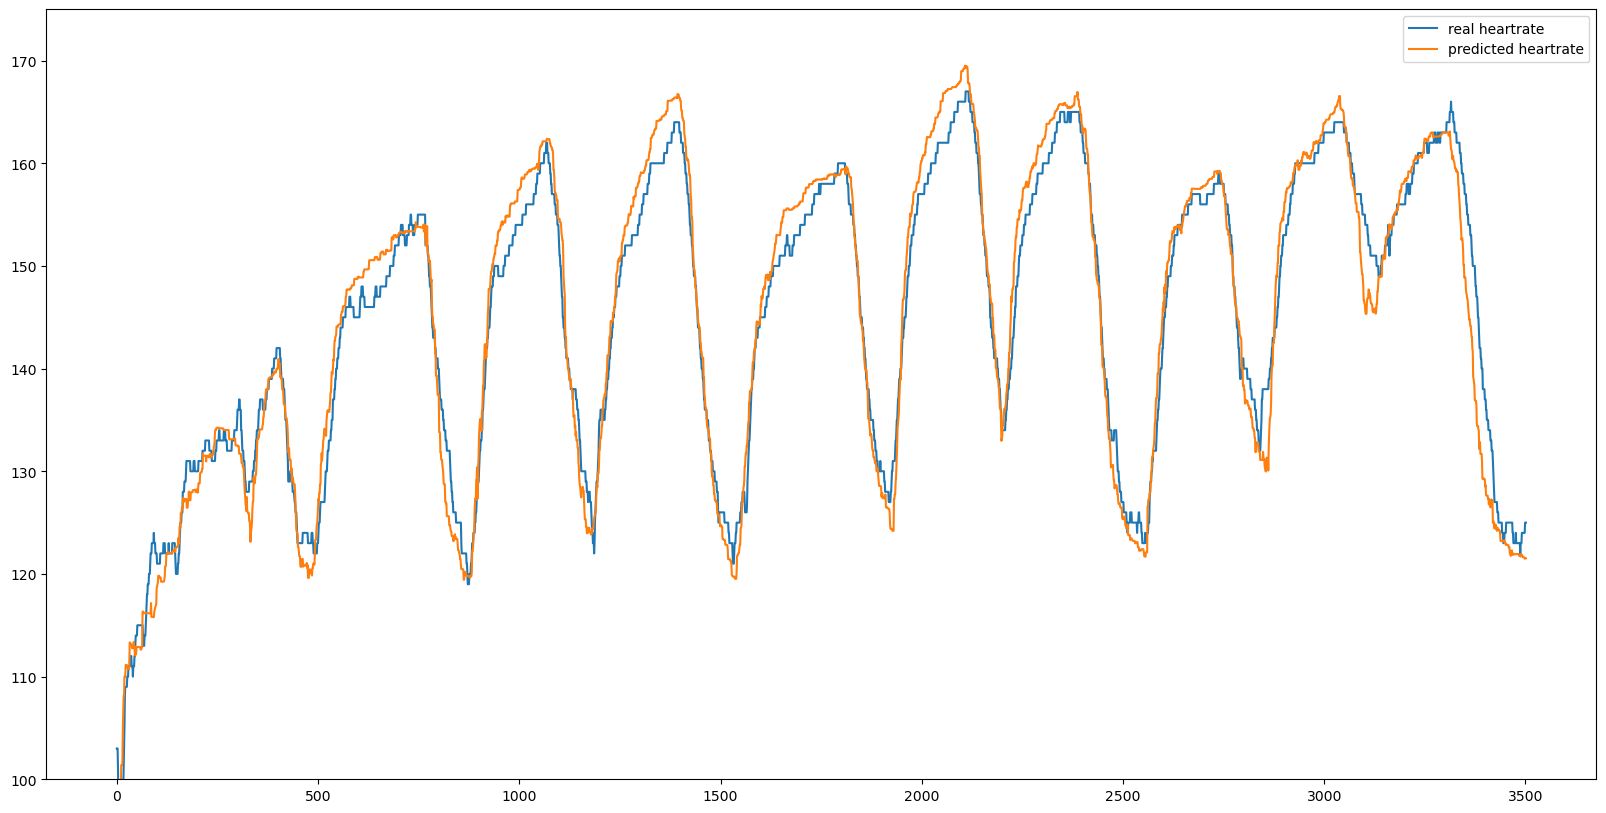

In [565]:
plot_activity(lgbm, 3025153587)

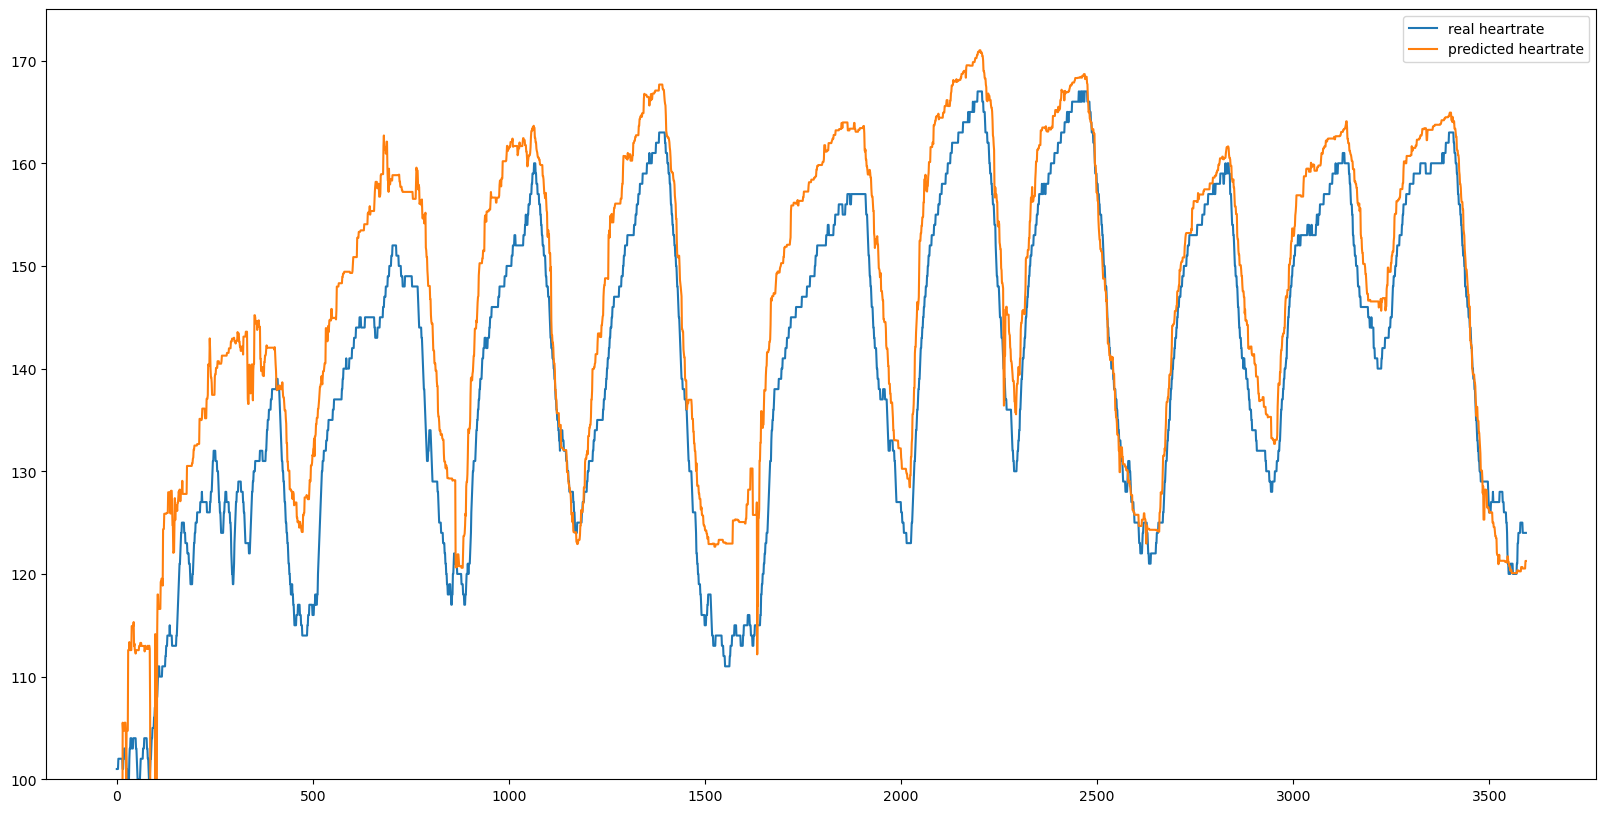

In [422]:
plot_activity(lgbm, 2987119442)

In [421]:
test_df.activity_id.unique()

array([3004307546, 2987119442], dtype=int64)

In [597]:
cond = val_df.heartrate.isna()
val_df[cond]

,activity_id,time,watts,heartrate,distance_x,velocity_smooth,altitude,cadence,heartrate_missing,hr_eq_0,hr_eq_0_shift1,hr_eq_0_shift_1,hr_eq_0_and_shifted,hr_eq_0_shifted_cumsum,hr_eq_0_shifted_cumsum_count,joules,watts_rolling,watts_rolling_mean_60s,watts_rolling_mean_120s,watts_rolling_mean_180s,watts_rolling_mean_240s,watts_rolling_mean_300s,watts_rolling_mean_360s,watts_rolling_mean_420s,watts_expanding_mean,watts_above_250,watts_above_300,watts_below_150,watts_below_150_shifted,watts_below_150_changed,watts_below_150_shifted_cumsum,time_below_150,watts_above_300_shifted,watts_above_300_changed,watts_above_300_shifted_cumsum,time_above_300,watts_above_250_shifted,watts_above_250_changed,watts_above_250_shifted_cumsum,time_above_250,mean_watts,moving_time,elapsed_time,weighted_mean_watts,elev_gain,kilojoules,average_speed,distance_y,year,hour,moving_time_min,elapsed_time_min,days_since,suffer_score_prev,suffer_score_rolling_mean_7,suffer_score_rolling_std_7,suffer_score_rolling_max_7,suffer_score_rolling_mean_14,suffer_score_rolling_std_14,suffer_score_rolling_max_14,suffer_score_rolling_mean_30,suffer_score_rolling_std_30,suffer_score_rolling_max_30,suffer_score_rolling_mean_60,suffer_score_rolling_std_60,suffer_score_rolling_max_60,suffer_score_rolling_mean_90,suffer_score_rolling_std_90,suffer_score_rolling_max_90,max_hr_rolling_mean_7,max_hr_rolling_std_7,max_hr_rolling_max_7,max_hr_rolling_mean_14,max_hr_rolling_std_14,max_hr_rolling_max_14,max_hr_rolling_mean_30,max_hr_rolling_std_30,max_hr_rolling_max_30,max_hr_rolling_mean_60,max_hr_rolling_std_60,max_hr_rolling_max_60,max_hr_rolling_mean_90,max_hr_rolling_std_90,max_hr_rolling_max_90,mean_hr_rolling_mean_7,mean_hr_rolling_std_7,mean_hr_rolling_max_7,mean_hr_rolling_mean_14,mean_hr_rolling_std_14,mean_hr_rolling_max_14,mean_hr_rolling_mean_30,mean_hr_rolling_std_30,mean_hr_rolling_max_30,mean_hr_rolling_mean_60,mean_hr_rolling_std_60,mean_hr_rolling_max_60,mean_hr_rolling_mean_90,mean_hr_rolling_std_90,mean_hr_rolling_max_90,mean_watts_rolling_mean_7,mean_watts_rolling_std_7,mean_watts_rolling_max_7,mean_watts_rolling_mean_14,mean_watts_rolling_std_14,mean_watts_rolling_max_14,mean_watts_rolling_mean_30,mean_watts_rolling_std_30,mean_watts_rolling_max_30,mean_watts_rolling_mean_60,mean_watts_rolling_std_60,mean_watts_rolling_max_60,mean_watts_rolling_mean_90,mean_watts_rolling_std_90,mean_watts_rolling_max_90,calories_rolling_mean_7,calories_rolling_std_7,calories_rolling_max_7,calories_rolling_mean_14,calories_rolling_std_14,calories_rolling_max_14,calories_rolling_mean_30,calories_rolling_std_30,calories_rolling_max_30,calories_rolling_mean_60,calories_rolling_std_60,calories_rolling_max_60,calories_rolling_mean_90,calories_rolling_std_90,calories_rolling_max_90,moving_time_rolling_mean_7,moving_time_rolling_std_7,moving_time_rolling_max_7,moving_time_rolling_mean_14,moving_time_rolling_std_14,moving_time_rolling_max_14,moving_time_rolling_mean_30,moving_time_rolling_std_30,moving_time_rolling_max_30,moving_time_rolling_mean_60,moving_time_rolling_std_60,moving_time_rolling_max_60,moving_time_rolling_mean_90,moving_time_rolling_std_90,moving_time_rolling_max_90,elapsed_time_rolling_mean_7,elapsed_time_rolling_std_7,elapsed_time_rolling_max_7,elapsed_time_rolling_mean_14,elapsed_time_rolling_std_14,elapsed_time_rolling_max_14,elapsed_time_rolling_mean_30,elapsed_time_rolling_std_30,elapsed_time_rolling_max_30,elapsed_time_rolling_mean_60,elapsed_time_rolling_std_60,elapsed_time_rolling_max_60,elapsed_time_rolling_mean_90,elapsed_time_rolling_std_90,elapsed_time_rolling_max_90,weighted_mean_watts_rolling_mean_7,weighted_mean_watts_rolling_std_7,weighted_mean_watts_rolling_max_7,weighted_mean_watts_rolling_mean_14,weighted_mean_watts_rolling_std_14,weighted_mean_watts_rolling_max_14,weighted_mean_watts_rolling_mean_30,weighted_mean_watts_rolling_std_30,weighted_mean_watts_rolling_max_30,weighted_mean_watts_rolling_mean_60,weighted_mean_watts_rolling_std_60,weighted_m

In [603]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'distance_x', 'velocity_smooth', 'altitude', 'cadence', 'heartrate_missing', 'hr_eq_0', 'hr_eq_0_shift1', 'hr_eq_0_shift_1', 'hr_eq_0_and_shifted', 'hr_eq_0_shifted_cumsum', 'hr_eq_0_shifted_cumsum_count', 'joules', 'watts_rolling', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s', 'watts_expanding_mean', 'watts_above_250', 'watts_above_300', 'watts_below_150', 'watts_below_150_shifted', 'watts_below_150_changed', 'watts_below_150_shifted_cumsum', 'time_below_150', 'watts_above_300_shifted', 'watts_above_300_changed', 'watts_above_300_shifted_cumsum', 'time_above_300', 'watts_above_250_shifted', 'watts_above_250_changed', 'watts_above_250_shifted_cumsum', 'time_above_250', 'mean_watts', 'moving_time', 'elapsed_time', 'weighted_mean_watts', 'elev_gain', 'kilojoules', 'average_speed', 'distance_y', 'year', 'hour', 'moving_ti

In [548]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'distance_x', 'velocity_smooth', 'altitude', 'cadence', 'hr_eq_0', 'hr_eq_0_shift1', 'hr_eq_0_shift_1', 'heartrate_missing', 'joules', 'watts_rolling', 'hr_eq_0_and_shifted', 'hr_eq_0_shifted_cumsum', 'hr_eq_0_shifted_cumsum_count', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s', 'watts_expanding_mean', 'watts_above_250', 'watts_above_300', 'watts_below_150', 'watts_below_150_shifted', 'watts_below_150_changed', 'watts_below_150_shifted_cumsum', 'time_below_150', 'watts_above_300_shifted', 'watts_above_300_changed', 'watts_above_300_shifted_cumsum', 'time_above_300', 'watts_above_250_shifted', 'watts_above_250_changed', 'watts_above_250_shifted_cumsum', 'time_above_250', 'mean_watts', 'moving_time', 'elapsed_time', 'weighted_mean_watts', 'elev_gain', 'kilojoules', 'average_speed', 'distance_y', 'year', 'hour', 'moving_ti

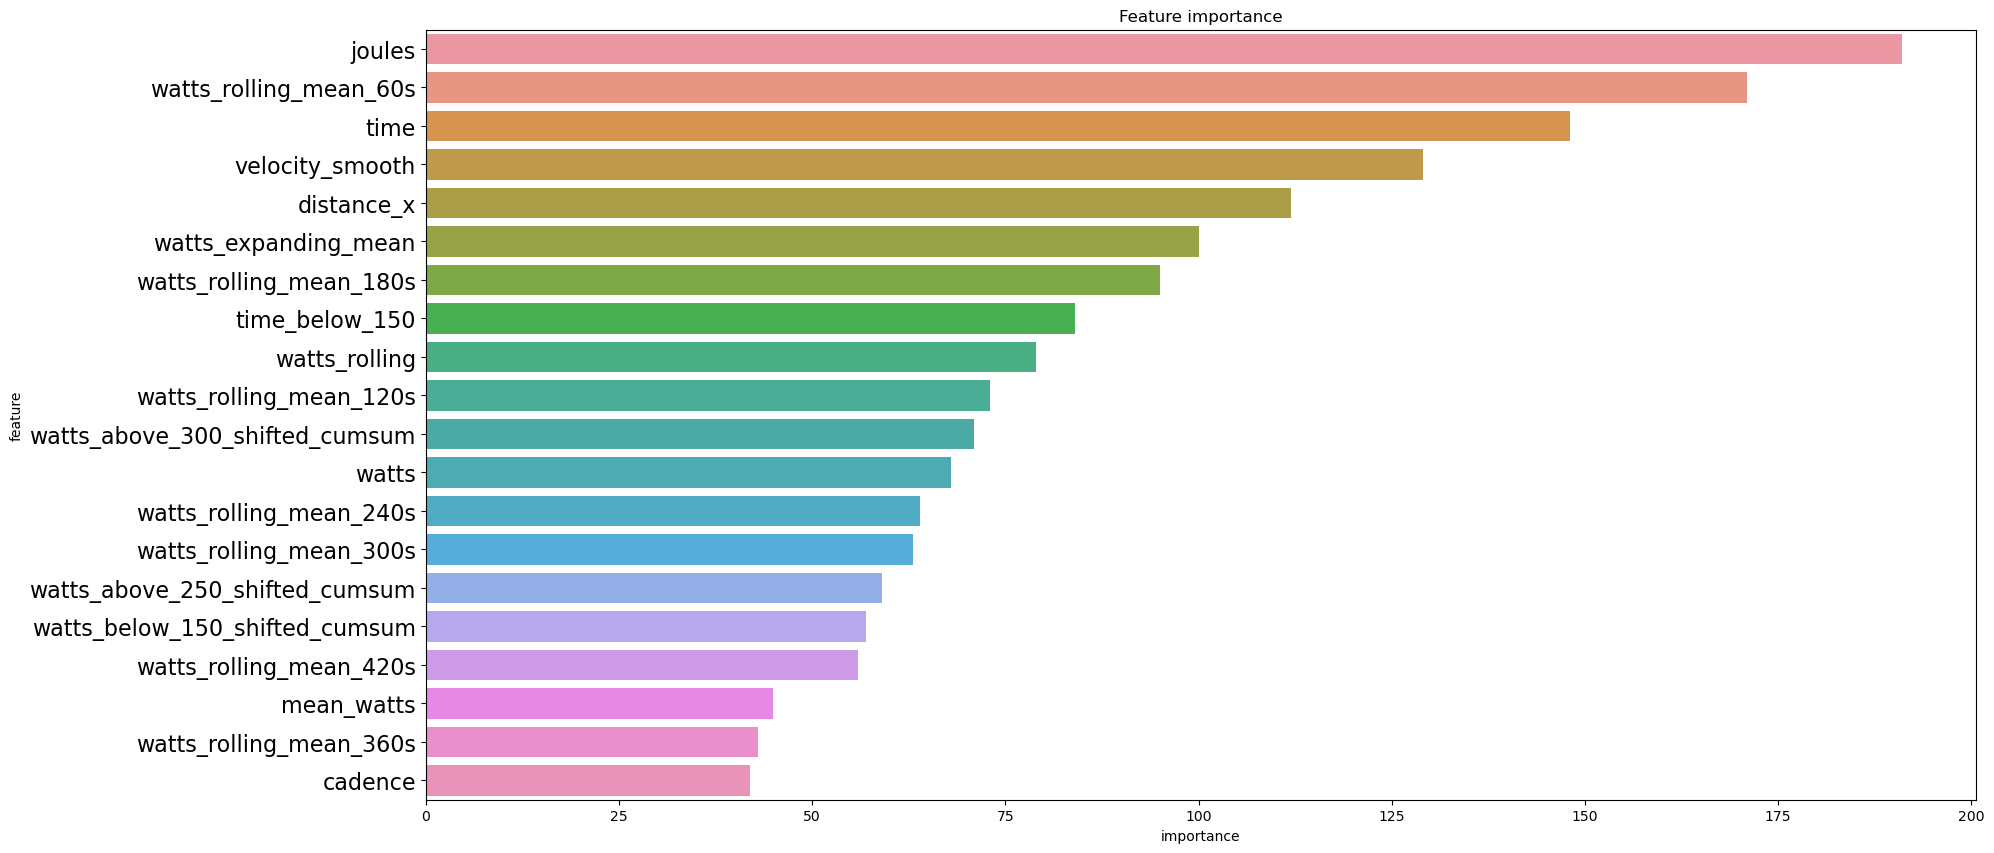

In [605]:
# get the feature importance from the model
feature_importance = pd.DataFrame({"feature": features, "importance": lgbm.feature_importances_})
# sort by importance
feature_importance = feature_importance.sort_values("importance", ascending=False)
# plot top 20 features
plt.figure(figsize=(20, 10))
# increase fontsize of yticks
plt.yticks(fontsize=16)
sns.barplot(x="importance", y="feature", data=feature_importance[:20])
plt.title("Feature importance")
plt.show()



In [606]:
feature_importance

,feature,importance
13,joules,191
15,watts_rolling_mean_60s,171
0,time,148
3,velocity_smooth,129
2,distance_x,112
22,watts_expanding_mean,100
17,watts_rolling_mean_180s,95
29,time_below_150,84
14,watts_rolling,79
16,watts_rolling_mean_120s,73


In [508]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'time_above_250', 'time_above_300', 'time_below_150', 'watts_above_250', 'watts_above_300', 'watts_expanding_mean', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s']
Train R2: 0.95, Train RMSE: 3.37, Train MAE: 2.46
Val R2: 0.90, Val RMSE: 4.88, Val MAE: 4.03
Test R2: 0.76, Test RMSE: 7.90, Test MAE: 6.51


In [466]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'time_above_250', 'time_above_300', 'time_below_150', 'watts_above_250', 'watts_above_300', 'watts_expanding_mean', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s']
Train R2: 0.95, Train RMSE: 4.71, Train MAE: 2.93
Val R2: 0.88, Val RMSE: 5.12, Val MAE: 4.04
Test R2: 0.74, Test RMSE: 8.55, Test MAE: 6.46


In [463]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'time_above_300', 'time_below_150', 'watts_above_250', 'watts_above_300', 'watts_expanding_mean', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s']
Train R2: 0.96, Train RMSE: 4.57, Train MAE: 2.72
Val R2: 0.88, Val RMSE: 5.22, Val MAE: 4.07
Test R2: 0.75, Test RMSE: 8.32, Test MAE: 6.13


In [442]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'time_below_150', 'watts_above_250', 'watts_above_300', 'watts_expanding_mean', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s']
Train R2: 0.96, Train RMSE: 4.35, Train MAE: 2.47
Val R2: 0.89, Val RMSE: 5.00, Val MAE: 3.88
Test R2: 0.80, Test RMSE: 7.53, Test MAE: 5.46


In [419]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'watts_above_250', 'watts_above_300', 'watts_expanding_mean', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s']
Train R2: 0.96, Train RMSE: 4.57, Train MAE: 2.51
Val R2: 0.89, Val RMSE: 4.89, Val MAE: 3.87
Test R2: 0.80, Test RMSE: 7.44, Test MAE: 5.31


In [414]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'watts_above_250', 'watts_expanding_mean', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s']
Train R2: 0.95, Train RMSE: 4.74, Train MAE: 2.74
Val R2: 0.88, Val RMSE: 5.21, Val MAE: 4.08
Test R2: 0.76, Test RMSE: 8.26, Test MAE: 6.17


In [391]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'watts_expanding_mean', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s', 'watts_rolling_mean_300s', 'watts_rolling_mean_360s', 'watts_rolling_mean_420s']
Train R2: 0.95, Train RMSE: 4.97, Train MAE: 2.95
Val R2: 0.89, Val RMSE: 5.10, Val MAE: 4.07
Test R2: 0.73, Test RMSE: 8.72, Test MAE: 6.65


In [389]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'watts_expanding_mean']
Train R2: 0.90, Train RMSE: 6.96, Train MAE: 4.26
Val R2: 0.88, Val RMSE: 5.26, Val MAE: 4.11
Test R2: 0.43, Test RMSE: 12.63, Test MAE: 9.47


In [386]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'watts_rolling_mean_60s', 'watts_rolling_mean_120s', 'watts_rolling_mean_180s', 'watts_rolling_mean_240s']
Train R2: 0.91, Train RMSE: 6.63, Train MAE: 4.00
Val R2: 0.86, Val RMSE: 5.61, Val MAE: 4.54
Test R2: 0.79, Test RMSE: 7.68, Test MAE: 5.62


In [384]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'watts_rolling_mean_240s']
Train R2: 0.83, Train RMSE: 8.82, Train MAE: 4.90
Val R2: 0.85, Val RMSE: 5.82, Val MAE: 4.50
Test R2: 0.61, Test RMSE: 10.41, Test MAE: 7.65


In [382]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'watts_rolling_mean_60s']
Train R2: 0.78, Train RMSE: 10.03, Train MAE: 5.01
Val R2: 0.86, Val RMSE: 5.71, Val MAE: 4.51
Test R2: 0.39, Test RMSE: 13.10, Test MAE: 7.36


In [380]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts', 'cadence']
Train R2: 0.78, Train RMSE: 10.04, Train MAE: 5.00
Val R2: 0.85, Val RMSE: 5.76, Val MAE: 4.44
Test R2: -0.26, Test RMSE: 18.73, Test MAE: 10.01


In [378]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time', 'watts']
Train R2: 0.68, Train RMSE: 12.15, Train MAE: 5.68
Val R2: 0.86, Val RMSE: 5.62, Val MAE: 4.48
Test R2: 0.43, Test RMSE: 12.66, Test MAE: 8.50


In [376]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)

Features: ['time']
Train R2: 0.57, Train RMSE: 14.15, Train MAE: 6.55
Val R2: 0.86, Val RMSE: 5.62, Val MAE: 4.67
Test R2: 0.48, Test RMSE: 12.05, Test MAE: 8.57


In [ ]:
train_predict_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, features)